In [1]:
!pip install gensim==4.1.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 108.6 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [2]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import zipfile
import json
import random
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt

In [3]:
EPOCHS = 50
LR = 1e-3
BS = 16
SEED = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(SEED) # Seed 고정

In [4]:
Attack_list = ['Bruteforce_CWE-307','CWE-89-SQL-injection','CVE-2014-0160']
'''Attack_list = ['Bruteforce_CWE-307','CVE-2019-5418', 'CVE-2020-13942', 'CVE-2020-23839', 
               'CVE-2014-0160', 'CWE-89-SQL-injection', 'CVE-2020-9484', 'CVE-2017-12635_6', 
               'CVE-2017-7529', 'CVE-2012-2122', 'CVE-2018-3760']'''
Base_dir = "/Users/cain/Desktop/Study/ML,DL_Project/LID-DS-2021_Preprocessing/LID-DS-2021/"
data_case_list = ['training','validation','test']
model_save_dir ='/Users/cain/Desktop/Study/ML,DL_Project/LID-DS-2021_Preprocessing/models/'

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [7]:
def Data_extract(name):
        Base_tmp_dir = Base_dir+name
        for e_1 in data_case_list:
            if e_1 == 'test':
                file_dir = Base_tmp_dir+"/"+ e_1 +"/"+"normal"
                file_list = sorted(os.listdir(file_dir))
                if '.DS_Store' in file_list:   
                    file_list.remove('.DS_Store') #Mac의 경우만 존재하는 것 같음 Mac환경이 아니라면 이 row를 무방함
                print(len(file_list))
                for e in tqdm(file_list):
                    fold_dir = file_dir+"/"+e.replace('.zip','')
                    os.mkdir(fold_dir)
                    myzip = zipfile.ZipFile(file_dir+"/"+e)
                    myzip.extractall(fold_dir)
                    os.remove(file_dir+"/"+e)#zip file 제거
                file_dir = Base_tmp_dir+"/"+ e_1 +"/"+"normal_and_attack"
                file_list = sorted(os.listdir(file_dir))
                if '.DS_Store' in file_list:   
                    file_list.remove('.DS_Store') #Mac의 경우만 존재하는 것 같음 Mac환경이 아니라면 이 row를 무방함
                print(len(file_list))
                for e in tqdm(file_list):
                    fold_dir = file_dir+"/"+e.replace('.zip','')
                    os.mkdir(fold_dir)
                    myzip = zipfile.ZipFile(file_dir+"/"+e)
                    myzip.extractall(fold_dir)
                    os.remove(file_dir+"/"+e)#zip file 제거
            else:
                file_dir = Base_tmp_dir+"/"+ e_1
                file_list = sorted(os.listdir(file_dir))
                if '.DS_Store' in file_list:   
                    file_list.remove('.DS_Store') #Mac의 경우만 존재하는 것 같음 Mac환경이 아니라면 이 row를 무방함
                print(len(file_list))
                for e in tqdm(file_list):
                    fold_dir = file_dir+"/"+e.replace('.zip','')
                    os.mkdir(fold_dir)
                    myzip = zipfile.ZipFile(file_dir+"/"+e)
                    myzip.extractall(fold_dir)
                    os.remove(file_dir+"/"+e)#zip file 제거

In [ ]:
for e in Attack_list: #unzip
    print(e)
    Data_extract(e)

Make .csv file part

In [ ]:
def make_csv(name): # .sc -> .csv
    Base_tmp_dir = Base_dir+name
    for e_1 in data_case_list:
            if e_1 == 'test':
                file_dir = Base_tmp_dir+"/"+ e_1 +"/"+"normal"
                fold_list = sorted(os.listdir(file_dir))
                if '.DS_Store' in fold_list:   
                    fold_list.remove('.DS_Store') #Mac의 경우만 존재하는 것 같음 Mac환경이 아니라면 이 row를 무방함
                print(len(fold_list))
                for e in tqdm(fold_list):
                    sample = pd.read_table(file_dir+"/"+e+"/"+e+".sc", header=None)
                    tmp = []
                    for i in range (sample.shape[0]):
                        x = sample[0][i]
                        sp = x.split(' ', 7)
                        tmp.append(sp)
                    data = pd.DataFrame(tmp,columns=['event_time','cpu','user_uid','process','process_id','event_type','event_direction','event_argument'])
                    data.reset_index(drop=True,inplace=True)
                    data.to_csv(file_dir+"/"+e+"/"+e+".csv")
                
                file_dir = Base_tmp_dir+"/"+ e_1 +"/"+"normal_and_attack"
                fold_list = sorted(os.listdir(file_dir))
                if '.DS_Store' in fold_list:   
                    fold_list.remove('.DS_Store') #Mac의 경우만 존재하는 것 같음 Mac환경이 아니라면 이 row를 무방함
                print(len(fold_list))
                for e in tqdm(fold_list):
                    sample = pd.read_table(file_dir+"/"+e+"/"+e+".sc", header=None)
                    tmp = []
                    for i in range (sample.shape[0]):
                        x = sample[0][i]
                        sp = x.split(' ', 7)
                        tmp.append(sp)
                    data = pd.DataFrame(tmp,columns=['event_time','cpu','user_uid','process','process_id','event_type','event_direction','event_argument'])
                    data.reset_index(drop=True,inplace=True)
                    data.to_csv(file_dir+"/"+e+"/"+e+".csv")

            else:
                file_dir = Base_tmp_dir+"/"+ e_1
                fold_list = sorted(os.listdir(file_dir))
                if '.DS_Store' in fold_list:   
                    fold_list.remove('.DS_Store') #Mac의 경우만 존재하는 것 같음 Mac환경이 아니라면 이 row를 무방함
                print(len(fold_list))
                for e in tqdm(fold_list):
                    sample = pd.read_table(file_dir+"/"+e+"/"+e+".sc", header=None)
                    tmp = []
                    for i in range (sample.shape[0]):
                        x = sample[0][i]
                        sp = x.split(' ', 7)
                        tmp.append(sp)
                    data = pd.DataFrame(tmp,columns=['event_time','cpu','user_uid','process','process_id','event_type','event_direction','event_argument'])
                    data.reset_index(drop=True,inplace=True)
                    data.to_csv(file_dir+"/"+e+"/"+e+".csv")


In [ ]:
for e in Attack_list: #.txt -> .csv converting part
    print(e)
    make_csv(e)

Make Outline_json file part

In [ ]:
def make_outline_json(name):
    Base_tmp_dir = Base_dir+name
    if "outline_json" not in os.listdir(Base_tmp_dir):
        os.mkdir(Base_tmp_dir+"/outline_json")
    for e_1 in data_case_list:
            scenario_name = []
            is_exploit = []
            recording_time =[]
            exploit_absolute = []
            victim_ip = []
            victim_name = []
            attacker_ip = []
            attacker_name = []
            if e_1 == 'test':
                file_dir = Base_tmp_dir+"/"+ e_1 +"/"+"normal"#normal file
                file_list = sorted(os.listdir(file_dir))
                if '.DS_Store' in file_list:   
                    file_list.remove('.DS_Store') #Mac의 경우만 존재하는 것 같음 Mac환경이 아니라면 이 row를 무방함
                print(len(file_list))
                for e in tqdm(file_list):
                    scenario_name.append(e)
                    with open(file_dir + "/"+e+"/"+e+".json", 'r', encoding='utf-8') as file:
                        json_data = json.load(file)
                    is_exploit.append(json_data['exploit'])
                    recording_time.append(json_data["recording_time"])
                    exploit_absolute.append(-1)
                    attacker_ip.append("no")
                    attacker_name.append("no")
                    victim_ip.append(json_data['container'][-1]['ip'])
                    victim_name.append(json_data['container'][-1]['name'])
                data = pd.DataFrame(zip(scenario_name,is_exploit,recording_time,exploit_absolute,
                                    victim_ip,victim_name,attacker_ip,attacker_name),
                                    columns=['scenario_name','is_exploit','recording_time','exploit_absolute',
                                    'victim_ip','victim_name','attacker_ip','attacker_name'])
                data.to_csv(Base_tmp_dir+"/outline_json/"+e_1+"_normal.csv")
                     
                scenario_name = []
                is_exploit = []
                recording_time =[]
                exploit_absolute = []
                victim_ip = []
                victim_name = []
                attacker_ip = []
                attacker_name = []
    
                file_dir = Base_tmp_dir+"/"+ e_1 +"/"+"normal_and_attack"#normal_and_attack_file
                file_list = sorted(os.listdir(file_dir))
                if '.DS_Store' in file_list:   
                    file_list.remove('.DS_Store') #Mac의 경우만 존재하는 것 같음 Mac환경이 아니라면 이 row를 무방함
                print(len(file_list))
                for e in tqdm(file_list):
                    scenario_name.append(e)
                    with open(file_dir + "/"+e+"/"+e+".json", 'r', encoding='utf-8') as file:
                        json_data = json.load(file)
                    is_exploit.append(json_data['exploit'])
                    recording_time.append(json_data["recording_time"])
                    tmp_str = str(json_data['time']['exploit'][0]['absolute']).replace('.','')
                    exploit_absolute.append(tmp_str)
                    attacker_ip.append(json_data['container'][-2]['ip'])
                    attacker_name.append(json_data['container'][-2]['name'])
                    victim_ip.append(json_data['container'][-1]['ip'])
                    victim_name.append(json_data['container'][-1]['name'])
                    print(json_data['exploit'])
                    #print("Is victim? : " + json_data['container'][-1]['role'])
                    #print("Is attack? : " + json_data['container'][-2]['role'])
        
                data = pd.DataFrame(zip(scenario_name,is_exploit,recording_time,exploit_absolute,
                                    victim_ip,victim_name,attacker_ip,attacker_name),
                                    columns=['scenario_name','is_exploit','recording_time','exploit_absolute',
                                    'victim_ip','victim_name','attacker_ip','attacker_name'])
                data.to_csv(Base_tmp_dir+"/outline_json/"+e_1+"_normal_and_attack.csv")
                   
            else: #validation or training
                file_dir = Base_tmp_dir+"/"+ e_1
                file_list = sorted(os.listdir(file_dir))
                if '.DS_Store' in file_list:   
                    file_list.remove('.DS_Store') #Mac의 경우만 존재하는 것 같음 Mac환경이 아니라면 이 row를 무방함
                print(len(file_list))
                for e in tqdm(file_list):
                    scenario_name.append(e)
                    with open(file_dir + "/"+e+"/"+e+".json", 'r', encoding='utf-8') as file:
                        json_data = json.load(file)
                    is_exploit.append(json_data['exploit'])
                    recording_time.append(json_data["recording_time"])
                    if json_data['exploit']==True:
                        tmp_str = str(json_data['time']['exploit'][0]['absolute']).replace('.','')
                        exploit_absolute.append(tmp_str)
                        attacker_ip.append(json_data['container'][-1]['ip'])
                        attacker_name.append(json_data['container'][-1]['name'])
                        victim_ip.append(json_data['container'][-2]['ip'])
                        victim_name.append(json_data['container'][-2]['name'])
                        
                    else:
                        exploit_absolute.append(-1)
                        attacker_ip.append("no")
                        attacker_name.append("no")
                        victim_ip.append(json_data['container'][-1]['ip'])
                        victim_name.append(json_data['container'][-1]['name'])
                data = pd.DataFrame(zip(scenario_name,is_exploit,recording_time,exploit_absolute,
                                    victim_ip,victim_name,attacker_ip,attacker_name),
                                    columns=['scenario_name','is_exploit','recording_time','exploit_absolute',
                                    'victim_ip','victim_name','attacker_ip','attacker_name'])
                data.to_csv(Base_tmp_dir+"/outline_json/"+e_1+".csv")
                            
                    
                   

In [ ]:
for e in Attack_list:
    make_outline_json(e)

In [ ]:
def detect_nan(name):
    Base_tmp_dir = Base_dir+name
    
    for e_1 in data_case_list:
        count=0
        if e_1 == 'test':
            file_dir = Base_tmp_dir+"/"+ e_1+"/normal"
            file_list = sorted(os.listdir(file_dir))
            if '.DS_Store' in file_list:   
                 file_list.remove('.DS_Store') #Mac의 경우만 존재하는 것 같음 Mac환경이 아니라면 이 row를 무방함
            print(len(file_list))
            print("TEST ONLY NORMAL")
            print("##########################################")
            for e in tqdm(file_list):
                sample = pd.read_csv(file_dir + "/" + e + "/" + e+".csv")
                if sample['process'].isnull().sum() != 0:
                    print('process detected')
                    print(e)
                    print(sample['process'].isnull().sum())
                    count = count+1
                if sample['event_type'].isnull().sum() != 0:
                    print('event_type detected')
                    print(e)
                    print(sample['event_type'].isnull().sum())
                    count = count+1
                if sample['cpu'].isnull().sum() != 0:
                    print('cpu detected')
                    print(e)
                    print(sample['cpu'].isnull().sum())
                    count = count+1
                if sample['user_uid'].isnull().sum() != 0:
                    print('user_uid detected')
                    print(e)
                    print(sample['user_uid'].isnull().sum())
                    count = count+1
                if sample['event_direction'].isnull().sum() != 0:
                    print('event_direction detected')
                    print(e)
                    print(sample['event_direction'].isnull().sum())
                    count = count+1
            print("---------------------------------------------")
            print("Detect complete" + name+ "normal test data")
            print(f"Total file has nan : {count}")
            print("---------------------------------------------")
            count=0
            file_dir = Base_tmp_dir+"/"+ e_1+"/normal_and_attack"
            file_list = sorted(os.listdir(file_dir))
            if '.DS_Store' in file_list:   
                 file_list.remove('.DS_Store') #Mac의 경우만 존재하는 것 같음 Mac환경이 아니라면 이 row를 무방함
            print(len(file_list))
            print("DETECT NORMAL AND ATTACK TEST DATA")
            print("##########################################")
            for e in tqdm(file_list):
                sample = pd.read_csv(file_dir + "/" + e + "/" + e+".csv")
                if sample['process'].isnull().sum() != 0:
                    print('process detected')
                    print(e)
                    print(sample['process'].isnull().sum())
                    count = count+1
                if sample['event_type'].isnull().sum() != 0:
                    print('event_type detected')
                    print(e)
                    print(sample['event_type'].isnull().sum())
                    count = count+1
                if sample['cpu'].isnull().sum() != 0:
                    print('cpu detected')
                    print(e)
                    print(sample['cpu'].isnull().sum())
                    count = count+1
                if sample['user_uid'].isnull().sum() != 0:
                    print('user_uid detected')
                    print(e)
                    print(sample['user_uid'].isnull().sum())
                    count = count+1
                if sample['event_direction'].isnull().sum() != 0:
                    print('event_direction detected')
                    print(e)
                    print(sample['event_direction'].isnull().sum())
                    count = count+1
            print("---------------------------------------------")
            print("Detect complete" + name+ " normal and test data")
            print(f"Total file has nan : {count}")
            print("---------------------------------------------")
        else:
            file_dir = Base_tmp_dir+"/"+ e_1
            file_list = sorted(os.listdir(file_dir))
            if '.DS_Store' in file_list:   
                 file_list.remove('.DS_Store') #Mac의 경우만 존재하는 것 같음 Mac환경이 아니라면 이 row를 무방함
            print(len(file_list))
            print("DETECT " + e_1)
            print("##########################################")
            for e in tqdm(file_list):
                sample = pd.read_csv(file_dir + "/" + e + "/" + e+".csv")
                if sample['process'].isnull().sum() != 0:
                    print('process detected')
                    print(e)
                    print(sample['process'].isnull().sum())
                    count = count+1
                if sample['event_type'].isnull().sum() != 0:
                    print('event_type detected')
                    print(e)
                    print(sample['event_type'].isnull().sum())
                    count = count+1
                if sample['cpu'].isnull().sum() != 0:
                    print('cpu detected')
                    print(e)
                    print(sample['cpu'].isnull().sum())
                    count = count+1
                if sample['user_uid'].isnull().sum() != 0:
                    print('user_uid detected')
                    print(e)
                    print(sample['user_uid'].isnull().sum())
                    count = count+1
                if sample['event_direction'].isnull().sum() != 0:
                    print('event_direction detected')
                    print(e)
                    print(sample['event_direction'].isnull().sum())
                    count = count+1
            print("---------------------------------------------")
            print("Detect Complete "+ name+" " + e_1+ " data")
            print(f"Total file has nan : {count}")
            print("---------------------------------------------")

In [ ]:
for name in Attack_list:
    print("Detect nan "+name)
    print("STARTING")
    detect_nan(name)

In [8]:
W2V_Sliding_size = 50
W2V_Window_size = 4
W2V_Vector_size = 50
w2v_model_name = 'word2vec_'+str(W2V_Sliding_size)+'_'+str(W2V_Window_size)+'_'+str(W2V_Vector_size)+'.model'
print(w2v_model_name)

word2vec_50_4_50.model


In [9]:
def W2V(name,sliding_size,window_size,v_size): # .sc -> .csv
    Base_tmp_dir = Base_dir+name
    file_dir = Base_tmp_dir+"/"+ 'training'
    file_list = sorted(os.listdir(file_dir))
    sentence = []
    if '.DS_Store' in file_list:   
         file_list.remove('.DS_Store') #Mac의 경우만 존재하는 것 같음 Mac환경이 아니라면 이 row를 무방함
    print(len(file_list))
    for e in tqdm(file_list):
        sample = pd.read_csv(file_dir + "/" + e + "/" + e+".csv")
        
        system_calls = sample['event_type']
        for i in range(len(system_calls)-sliding_size+1):
            if system_calls[i:i+sliding_size].tolist() not in sentence:
                sentence.append(system_calls[i:i+sliding_size].tolist())
    model = Word2Vec(sentences=sentence, vector_size=v_size, window=window_size, workers=4, sg=1, seed=SEED)
    return model

In [21]:
w2v_model = W2V('CVE-2014-0160',W2V_Sliding_size,W2V_Window_size,W2V_Vector_size)
#model = W2V('CWE-89-SQL-injection',W2V_Sliding_size,W2V_Window_size,W2V_Vector_size)
#plz set attack name
w2v_model.save(model_save_dir+'w2v/'+ w2v_model_name)
#CAUTION!!!!!!!!!!!!!!!!
#CAUTION!!!!!!!!!!!!!!!!
#CAUTION!!!!!!!!!!!!!!!!
#CAUTION!!!!!!!!!!!!!!!!
#CAUTION!!!!!!!!!!!!!!!!
#CAUTION!!!!!!!!!!!!!!!!
#CAUTION!!!!!!!!!!!!!!!!
#CAUTION!!!!!!!!!!!!!!!!
#CAUTION!!!!!!!!!!!!!!!!
#CAUTION!!!!!!!!!!!!!!!!

210


100%|██████████| 210/210 [15:23<00:00,  4.40s/it]


In [10]:
#load embedding model
w2v_model = Word2Vec.load(model_save_dir+'w2v/'+w2v_model_name)

In [11]:
def embedding_syscall(syscall): #해당하는 w2v모델과 공격이 일치하는지 확인해야함.
    embedding_vector = w2v_model.wv.get_vector(syscall)
    return embedding_vector

In [12]:
scaler= MinMaxScaler() #Use MinMaxScaler

In [13]:
def extract_params(arg_list): #extract r
    arg_list = arg_list.astype(str)
    res = []
    size = []
    fd = []
    for i in range(len(arg_list)):
        tmp = arg_list[i].strip().split(' ')
        params = {}
        for e in tmp:
            try:
                split = e.split('=',1)
                params[split[0]] = split[1]
            except:
                pass
        try:
            if int(params['res']) < 10000000:
                res.append(int(params['res']))
            else:
                res.append(-1)
        except:
            res.append(0)
      
        try:
            if int(params['size']) < 10000000:
                size.append(int(params['size']))
            else:
                size.append(-1)
        except:             
            size.append(0)
        try:
            tmp_fd = params['fd'].split('(')[0]  
            if int(tmp_fd) < 10000000:
                fd.append(tmp_fd)
    
            else:
                fd.append(-1)
        except:             
            fd.append(0)
    return res, size, fd;

In [14]:
def make_training(name):
    Base_tmp_dir = Base_dir+name
    file_dir = Base_tmp_dir+"/"+ 'training'
    file_list = sorted(os.listdir(file_dir))
    if '.DS_Store' in file_list:   
         file_list.remove('.DS_Store') #Mac의 경우만 존재하는 것 같음 Mac환경이 아니라면 이 row를 무방함
    print(len(file_list))
    sample_event_direction = []
    sample_event_type = []
    #sample_cpu = []
    sample_user_uid = []
    sample_res = []
    sample_size = []
    sample_fd = []
    file_list = file_list[:100]
    for e in tqdm(file_list):
        sample = pd.read_csv(file_dir + "/" + e + "/" + e+".csv")
        sample_event_direction.extend(sample['event_direction'])
        
        sample_event_type_tmp = sample['event_type'].tolist()
        sample_event_type_tmp = list(map(embedding_syscall,sample_event_type_tmp))
        sample_event_type.extend(sample_event_type_tmp)
        #sample_cpu.extend(sample['cpu'])
        sample_user_uid.extend(sample['user_uid'])
        sample_param = sample['event_argument']
        tmp_res, tmp_size, tmp_fd = extract_params(sample_param)
        sample_fd.extend(tmp_fd)
        sample_res.extend(tmp_res)
        sample_size.extend(tmp_size)
        
   # return_x = pd.DataFrame(zip(sample_cpu,sample_user_uid), columns=['cpu','user_uid'])
    return_x = pd.DataFrame(zip(sample_user_uid,sample_res,sample_size,sample_fd),columns =['user_uid','res','size','fd'])
    '''
    Normalization part
    '''
    return_x = scaler.fit_transform(return_x)
    return_x = pd.DataFrame(return_x,columns=['uid','res','size','fd'])
    
    return_x['event_direction'] = sample_event_direction
    return_x = pd.get_dummies(return_x, columns=['event_direction'])
    sample_event_type_df = pd.DataFrame(sample_event_type)
    return_x = pd.concat([return_x, sample_event_type_df],axis=1)
    

    
    return return_x
    

In [15]:
def make_validation(name):
    Base_tmp_dir = Base_dir+name
    file_dir = Base_tmp_dir+"/"+ 'validation'
    file_list = sorted(os.listdir(file_dir))
    if '.DS_Store' in file_list:   
         file_list.remove('.DS_Store') #Mac의 경우만 존재하는 것 같음 Mac환경이 아니라면 이 row를 무방함
    print(len(file_list))
    sample_event_direction = []
    sample_event_type = []
    #sample_cpu = []
    sample_user_uid = []
    sample_res = []
    sample_size = []
    sample_fd = []
    file_list = file_list[:10]
    for e in tqdm(file_list):
        sample = pd.read_csv(file_dir + "/" + e + "/" + e+".csv")
        sample_event_direction.extend(sample['event_direction'])
        
        sample_event_type_tmp = sample['event_type'].tolist()
        sample_event_type_tmp = list(map(embedding_syscall,sample_event_type_tmp))
        sample_event_type.extend(sample_event_type_tmp)
      
        
        #sample_cpu.extend(sample['cpu'])
        sample_user_uid.extend(sample['user_uid'])
        sample_param = sample['event_argument']
        tmp_res, tmp_size,tmp_fd = extract_params(sample_param)
        sample_res.extend(tmp_res)
        sample_size.extend(tmp_size)
        sample_fd.extend(tmp_fd)
        
   # return_x = pd.DataFrame(zip(sample_cpu,sample_user_uid), columns=['cpu','user_uid'])
    return_x = pd.DataFrame(zip(sample_user_uid,sample_res,sample_size,sample_fd),
                            columns =['user_uid','res','size','fd'])
    return_x = scaler.transform(return_x)
    return_x = pd.DataFrame(return_x,columns=['uid','res','size','fd'])
    
    
    return_x['event_direction'] = sample_event_direction
    return_x = pd.get_dummies(return_x, columns=['event_direction'])
    sample_event_type_df = pd.DataFrame(sample_event_type)
    return_x = pd.concat([return_x, sample_event_type_df],axis=1)
    
    return return_x
    

In [16]:
training_data = make_training('CVE-2014-0160')
validation_data = make_validation('CVE-2014-0160')
#plz set attack name..
print(training_data.shape)
print(validation_data.shape)

210


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 65.51it/s]


60


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 89.13it/s]


(372489, 56)
(27736, 56)


In [19]:
training_data

,uid,res,size,fd,event_direction_<,event_direction_>,0,1,2,3,...,40,41,42,43,44,45,46,47,48,49
0,0.050570,0.000122,0.0,0.606061,1,0,-0.610910,-0.098344,-0.133263,0.438859,...,0.356400,0.352074,-0.051482,-0.142951,0.235462,0.224490,0.225513,-0.087178,-0.085136,0.041496
1,0.050570,0.000061,0.0,0.606061,0,1,-0.488277,0.017474,0.025815,0.485536,...,0.239358,0.532692,-0.065075,-0.344685,0.067742,-0.025019,0.352096,-0.033449,0.081670,0.202076
2,0.050570,0.000061,0.0,0.969697,1,0,-0.488277,0.017474,0.025815,0.485536,...,0.239358,0.532692,-0.065075,-0.344685,0.067742,-0.025019,0.352096,-0.033449,0.081670,0.202076
3,0.050570,0.000061,0.0,0.606061,0,1,-0.563836,-0.095974,-0.255534,0.422781,...,0.363079,0.387809,-0.010614,-0.390050,0.194146,0.217769,0.157911,0.066509,0.032996,0.118786
4,0.050570,0.000061,0.0,0.606061,1,0,-0.563836,-0.095974,-0.255534,0.422781,...,0.363079,0.387809,-0.010614,-0.390050,0.194146,0.217769,0.157911,0.066509,0.032996,0.118786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372484,0.141273,0.000061,0.0,0.606061,0,1,-0.530712,0.056233,-0.182155,0.602559,...,0.081353,0.809120,-0.244101,-0.594368,0.438858,0.144498,0.032961,-0.209092,-0.611227,0.263604
372485,0.141273,0.000061,0.0,0.606061,1,0,-0.530712,0.056233,-0.182155,0.602559,...,0.081353,0.809120,-0.244101,-0.594368,0.438858,0.144498,0.032961,-0.209092,-0.611227,0.263604
372486,0.141273,0.000061,0.0,0.606061,0,1,-0.647395,0.047720,0.096649,0.593189,...,-0.228299,0.573070,-0.308945,-0.697104,0.516139,0.124185,0.104502,-0.273971,-0.552915,0.170225
372487,0.141273,0.000061,0.0,0.606061,1,0,-0.647395,0.047720,0.096649,0.593189,...,-0.228299,0.573070,-0.308945,-0.697104,0.516139,0.124185,0.104502,-0.273971,-0.552915,0.170225


In [17]:
model_input_sliding_size = 30 #timestamp

In [18]:
def making_model_input(x,model_input_sliding_size):
    s_size = model_input_sliding_size
    x = np.array(x)
    data = []
    for i in tqdm(range(x.shape[0]-s_size+1)):
        data.append(x[i:i+s_size][:])
    
    return_data = np.array(data)
    return return_data

In [19]:
#Make model input 
train_x = making_model_input(training_data,model_input_sliding_size)
val_x  = making_model_input(validation_data,model_input_sliding_size)

100%|█████████████████████████████████████████████████████████████████████████████████████| 27707/27707 [00:00<00:00, 2847276.27it/s]


In [20]:
print(train_x.shape) #shape[0] -> Data - sliding_size + 1
#val_x = val_x[:10000]
print(val_x.shape)

(372460, 30, 56)
(27707, 30, 56)


In [21]:
import gc
gc.collect()

698

In [22]:
class MyDataset(Dataset):
    def __init__(self, data):
        self.data=data

    def __getitem__(self, index):
        self.x = self.data[index]
        return torch.from_numpy(self.x)

    def __len__(self):
        return len(self.data)


In [23]:
train_dataset = MyDataset(train_x)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=False, num_workers=0)

val_dataset = MyDataset(val_x)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=0)

In [24]:
len(val_dataset)

27707

In [25]:
it = iter(val_loader)
sample_train = next(it)
print(sample_train.shape)

torch.Size([16, 30, 56])


In [26]:
len(train_dataset)

372460

In [ ]:
class TimeDistributed(nn.Module):
    #https://discuss.pytorch.org/t/any-pytorch-function-can-work-as-keras-timedistributed/1346/4
    def __init__(self, module, batch_first=False):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):

        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)

        y = self.module(x_reshape)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)

        return y

In [27]:
model_name = 'Conv1dBiLSTM_w2vsize_'+str(W2V_Sliding_size)+'_'+str(W2V_Window_size)+'_'+str(W2V_Vector_size)+'_time_'+ str(model_input_sliding_size)
model_name = model_name + '_layer_256'
print(model_name)

Conv1dBiLSTM_w2vsize_50_4_50_time_30_layer_256


In [28]:
class AutoEncoder(nn.Module):
    def __init__(self,feature_num):
        super(AutoEncoder, self).__init__()
        self.feature_num = feature_num
        self.conv1d_1 = nn.Conv1d(in_channels = self.feature_num,out_channels=128,kernel_size=8,stride=1,padding='same')
        self.lstm_1 = nn.LSTM(128,32,batch_first=True,bidirectional=True)
        self.lstm_2 = nn.LSTM(64,16,batch_first=True,bidirectional=True)
        self.lstm_3 = nn.LSTM(32,8,batch_first=True,bidirectional=True)
        self.lstm_4 = nn.LSTM(16,16,batch_first=True,bidirectional=True)
        self.lstm_5 = nn.LSTM(32,32,batch_first=True,bidirectional=True)
        self.conv1d_2 = nn.Conv1d(in_channels =64 ,out_channels=128,kernel_size=8,stride=1,padding='same')
        self.output = nn.Linear(128,self.feature_num)
        self.tanh = nn.Tanh()

    def forward(self, x):

        x = x.transpose(1, 2).contiguous()
        x = self.conv1d_1(x)
        x = x.transpose(1, 2).contiguous()
        x = self.tanh(x)
        x, _ = self.lstm_1(x)
        x = self.tanh(x)
        x, _  = self.lstm_2(x)
        x = self.tanh(x)
        x, _  = self.lstm_3(x)
        x = self.tanh(x)
        x, _  = self.lstm_4(x)
        x = self.tanh(x)
        x, _  = self.lstm_5(x)
        x = self.tanh(x)
        x = x.transpose(1, 2).contiguous()
        x = self.conv1d_2(x)
        x = x.transpose(1, 2).contiguous()
        x = self.tanh(x)
        x = self.output(x)
        return x
    

In [29]:
class AutoEncoder(nn.Module):
    def __init__(self,feature_num):
        super(AutoEncoder, self).__init__()
        self.feature_num = feature_num
        self.lstm_1 = nn.LSTM(feature_num,64,batch_first=True)
        self.lstm_2 = nn.LSTM(64,128,batch_first=True)
        self.lstm_3 = nn.LSTM(128,256,batch_first=True)
        self.lstm_4 = nn.LSTM(256,128,batch_first=True)
        self.lstm_5 = nn.LSTM(128,64,batch_first=True)
        self.output= nn.Linear(64,feature_num)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x, _ = self.lstm_1(x)
        x = self.tanh(x)
        x, _  = self.lstm_2(x)
        x = self.tanh(x)
        x, _  = self.lstm_3(x)
        x = self.tanh(x)
        x, _  = self.lstm_4(x)
        x = self.tanh(x)
        x, _  = self.lstm_5(x)
        x = self.tanh(x)
        x = self.output(x)
        return x
    

In [28]:
class Trainer():
    def __init__(self, model, optimizer, train_loader,train_dataset, val_loader,val_dataset, scheduler, device):
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.train_dataset = train_dataset
        self.val_loader = val_loader
        self.val_dataset = val_dataset
        self.scheduler = scheduler
        self.device = device
        # Loss Function
        self.criterion = nn.MSELoss().to(device)
        
    def fit(self, ):
        self.model.to(self.device)
        best_score = 10000000000
        batch_size = len(train_loader)
        for epoch in range(EPOCHS):
            self.model.train()
            i=0
            avg_loss = 0
            print(f'Epoch : [{epoch}]')
            for x in iter(self.train_loader):
                self.optimizer.zero_grad()
                x = x.float().to(self.device)
                _x = self.model(x)
                loss = self.criterion(_x, x)
                loss.backward()
                self.optimizer.step()
                avg_loss += loss.item()
                #print(f'{loss.item():e}')
                i = i+1
                print(f'\r loss : {avg_loss/i:e} [{i:>5d}/{batch_size:>5d}]',end='')
                
            score = self.validation(self.model)

            print(f'\nVal Loss : {score:e}')

            #if self.scheduler is not None:
            #   self.scheduler.step(score)

            if best_score > score:
                best_score = score
                torch.save(model.module.state_dict(), model_save_dir+'DL/'+model_name+'.pth', _use_new_zipfile_serialization=False)
        return model
    def validation(self, eval_model):
        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        eval_model.eval()
        loss = 0
        i=0
        with torch.no_grad():
            for x in iter(self.val_loader):
                x = x.float().to(self.device)
                _x = self.model(x)
                loss += self.criterion(_x,x).item()
                i=i+1
                #rmse = torch.sqrt(mse).cpu().tolist()
                #diff = cos(x, _x).cpu().tolist()
                #tmp_mse += diff
                #batch_pred = np.where(np.array(diff)<thr, 1,0).tolist()
                #pred += batch_pred
                #true += y.tolist()
        #plt.plot(mse)
        #plt.axhline(thr, color='r', linewidth=1)
        loss = loss/i
        return loss

In [29]:
class Trainer():
    def __init__(self, model, optimizer, train_loader, train_dataset, val_loader, val_dataset, scheduler, device):
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.train_dataset = train_dataset
        self.val_loader = val_loader
        self.val_dataset = val_dataset
        self.scheduler = scheduler
        self.device = device
        # Loss Function
        self.criterion = nn.MSELoss().to(device)
        
    def fit(self, ):
        self.model.to(self.device)
        best_score = 10000000000
        batch_size = len(train_loader)
        for epoch in range(EPOCHS):
            self.model.train()
            i=0
            avg_loss = 0
            print(f'Epoch : [{epoch}]')
            for x in iter(self.train_loader):
                self.optimizer.zero_grad()
                x = x.float().to(self.device)
                _x = self.model(x)
                loss = self.criterion(_x, x)
                loss.backward()
                self.optimizer.step()
                avg_loss += loss.item()
                #print(f'{loss.item():e}')
                i = i+1
                print(f'\r loss : {avg_loss/i:e} [{i:>5d}/{batch_size:>5d}]',end='')

           
            score = 0
            with torch.no_grad():
                self.model.eval()
                for x in iter(self.val_loader):
                    x = x.float().to(self.device)
                    _x = self.model(x)
                    score += self.criterion(_x,x).item()
            score = score/len(val_loader)
            print(f'\nVal Loss : {score:e}')

            #if self.scheduler is not None:
            #   self.scheduler.step(score)

            if best_score > score:
                best_score = score
                torch.save(model.module.state_dict(), model_save_dir+'DL/'+model_name+'.pth', _use_new_zipfile_serialization=False)
        return model

In [30]:
def init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Conv1d):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'bias' in name:
                        nn.init.zeros_(param)
                    elif 'weight' in name:
                        nn.init.xavier_normal_(param)

In [ ]:
model = nn.DataParallel(AutoEncoder(sample_train.shape[2]))
model.to(device)
#model = AutoEncoder(sample_train.shape[2])
#init_weight(model)
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, threshold_mode='abs', min_lr=1e-8, verbose=True)
trainer = Trainer(model, optimizer, train_loader,train_dataset, val_loader,val_dataset ,scheduler, device)
print(summary(model,(sample_train.shape[0],sample_train.shape[1],sample_train.shape[2])))
trained_model = trainer.fit()

/opt/homebrew/Caskroom/miniforge/base/envs/cain/lib/python3.8/site-packages/torch/nn/modules/conv.py:298: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1647804319176/work/aten/src/ATen/native/Convolution.cpp:744.)
  return F.conv1d(input, weight, bias, self.stride,


Layer (type:depth-idx)                   Output Shape              Param #
DataParallel                             [16, 30, 56]              --
├─AutoEncoder: 1-1                       [16, 30, 56]              --
│    └─Conv1d: 2-1                       [16, 128, 30]             57,472
│    └─Tanh: 2-2                         [16, 30, 128]             --
│    └─LSTM: 2-3                         [16, 30, 64]              41,472
│    └─Tanh: 2-4                         [16, 30, 64]              --
│    └─LSTM: 2-5                         [16, 30, 32]              10,496
│    └─Tanh: 2-6                         [16, 30, 32]              --
│    └─LSTM: 2-7                         [16, 30, 16]              2,688
│    └─Tanh: 2-8                         [16, 30, 16]              --
│    └─LSTM: 2-9                         [16, 30, 32]              4,352
│    └─Tanh: 2-10                        [16, 30, 32]              --
│    └─LSTM: 2-11                        [16, 30, 64]              

In [141]:
#print(model(sample_train.float()).shape)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
model.to(device)
print(summary(model,(16,30,56)))

1586232
torch.Size([16, 30, 256])
torch.Size([16, 30, 256])
torch.Size([16, 30, 128])
torch.Size([16, 30, 64])
torch.Size([16, 30, 128])
torch.Size([16, 30, 256])
torch.Size([16, 30, 56])
Layer (type:depth-idx)                   Output Shape              Param #
DataParallel                             [16, 30, 56]              --
├─AutoEncoder: 1-1                       [16, 30, 56]              --
│    └─Conv1d: 2-1                       [16, 256, 30]             114,944
│    └─Tanh: 2-2                         [16, 30, 256]             --
│    └─LSTM: 2-3                         [16, 30, 256]             395,264
│    └─Tanh: 2-4                         [16, 30, 256]             --
│    └─LSTM: 2-5                         [16, 30, 128]             164,864
│    └─Tanh: 2-6                         [16, 30, 128]             --
│    └─LSTM: 2-7                         [16, 30, 64]              41,472
│    └─Tanh: 2-8                         [16, 30, 64]              --
│    └─LSTM: 2-9  

In [228]:
loaded_model = AutoEncoder(sample_train.shape[2])
loaded_model.load_state_dict(torch.load(model_save_dir+'DL/'+model_name+'.pth'))#torch로 수정
#loaded_model.to(device)
#summary_(loaded_model,(sample_train.shape[1],sample_train.shape[2]),batch_size=BS)
print(loaded_model)
#weights, bias = loaded_model.layers[0].get_weights()
#print(weights[0])
#loaded_model.compile(optimizer='adam', loss='mse')

AutoEncoder(
  (conv1d_1): Conv1d(56, 256, kernel_size=(8,), stride=(1,), padding=same)
  (lstm_1): LSTM(256, 128, batch_first=True, bidirectional=True)
  (lstm_2): LSTM(256, 64, batch_first=True, bidirectional=True)
  (lstm_3): LSTM(128, 32, batch_first=True, bidirectional=True)
  (lstm_4): LSTM(64, 64, batch_first=True, bidirectional=True)
  (lstm_5): LSTM(128, 128, batch_first=True, bidirectional=True)
  (conv1d_2): Conv1d(256, 256, kernel_size=(8,), stride=(1,), padding=same)
  (output): Linear(in_features=256, out_features=56, bias=True)
  (tanh): Tanh()
)


In [229]:
def make_2d(x):
    arr = np.empty((x.shape[0],x.shape[2]))
    #print(arr.shape)
    for i in range(x.shape[0]):
            arr[i] = x[i,(x.shape[1]-1),:]
    return arr

In [230]:
def make_label(directory , scenario_name):
    sample = pd.read_csv(directory+"/test/normal_and_attack/"+scenario_name+"/"+scenario_name+".csv",index_col=0)
    json_csv = pd.read_csv(directory+'/outline_json/test_normal_and_attack.csv',index_col=0)
    #print(json_csv)
    tmp_json_csv =json_csv.loc[json_csv['scenario_name'] == scenario_name,'exploit_absolute']
    tmp_json_csv = tmp_json_csv.astype(str)
    tmp_json_csv = tmp_json_csv.tolist()
    #print(tmp_json_csv)
    start_ex = tmp_json_csv[0][:12]
    start_ex = int(start_ex)
    
    event_record_time = sample['event_time']
    event_record_time = event_record_time.astype(str)
    event_record_time = event_record_time.apply(lambda x : x[:12])
    event_record_time = event_record_time.astype(int)
    
    label = event_record_time[(event_record_time == start_ex)]
    label_1s = event_record_time[(event_record_time == start_ex+1)]
    label_2s = event_record_time[(event_record_time == start_ex+2)]
    #timestamp의 오차로 인해 향후 0.02초까지 공격이라고 판정
    label = label.index.tolist()
    
    if(len(label_1s)>0):
        label_1s = label_1s.index.tolist()
        label.extend(label_1s)
        if(len(label_2s)>0):
            label.extend(label_2s.index.tolist())
    real_label = [label[0],len(label)]
    return real_label
    


In [231]:
def test_pytorch(model, test_loader, device):
  model.to(device)
  model.eval()
  output = []
  i=0
  with torch.no_grad():
    for x in iter(test_loader):
      x = x.float().to(device)
      _x = model(x)
      _x = _x.cpu().numpy().tolist()
      output.extend(_x)
  output = np.array(output)
  print(output.shape)
  return output

In [236]:
def testing(name,threshold):
    Base_tmp_dir = Base_dir+name
    file_dir = Base_tmp_dir+"/"+ 'test/normal_and_attack'
    #Use normal_and_attack data
    
    file_list = sorted(os.listdir(file_dir))
    if '.DS_Store' in file_list:   
         file_list.remove('.DS_Store') #Mac의 경우만 존재하는 것 같음 Mac환경이 아니라면 이 row를 무방함
    #print(len(file_list))
    
    attack_data_count = len(file_list)
    real_anomaly_count = 0
    false_positive_count = 0
    
    for e in tqdm(file_list):
        #print(e)
        sample_event_direction = []
        sample_event_type = []
        sample_user_uid = []
        sample_res = []
        sample_size = []
        sample_fd = []
        
        sample = pd.read_csv(file_dir + "/" + e + "/" + e+".csv")
        
        
        sample_event_direction.extend(sample['event_direction'])
        
    
        sample_event_type_tmp = sample['event_type'].tolist()
        sample_event_type_tmp = list(map(embedding_syscall,sample_event_type_tmp))
        sample_event_type.extend(sample_event_type_tmp)
      
        sample_user_uid.extend(sample['user_uid'])
        
        sample_param = sample['event_argument']
        
        tmp_res, tmp_size, tmp_fd= extract_params(sample_param)
        
        sample_res.extend(tmp_res)
        sample_size.extend(tmp_size)
        sample_fd.extend(tmp_fd)
   
        return_x = pd.DataFrame(zip(sample_user_uid,sample_res,sample_size,sample_fd),columns=['user_uid','res','size','fd'])        
        
        return_x = scaler.transform(return_x)
        return_x = pd.DataFrame(return_x,columns=['user_uid','res','size','fd'])
        
        
        return_x['event_direction'] = sample_event_direction
        return_x = pd.get_dummies(return_x, columns=['event_direction'])
        sample_event_type_df = pd.DataFrame(sample_event_type)
        return_x = pd.concat([return_x, sample_event_type_df],axis=1)
        
        test_x = making_model_input(return_x,model_input_sliding_size)
        test_dataset = MyDataset(test_x)
        test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=False, num_workers=0)

        predict = test_pytorch(loaded_model,test_loader,device)
        pred = make_2d(predict)

        test_chk = return_x[model_input_sliding_size-1:]
        error = test_chk- pred
        mse = np.mean(np.power(error,2),axis=1)
        mean_window = mse.rolling(30,center=True).mean()
        window_error = mean_window.fillna(0)
        window_error.reset_index(drop=True,inplace=True)
        #mse = mse.reset_index()
        plt.plot(window_error)
        plt.axhline(y=threshold, color='r', linewidth=1)
        plt.show()
    
        real_label = make_label(Base_tmp_dir,e)
        ''' cos_similarity = np.array([])
        testing_1= torch.tensor(test_chk.values)
        testing_2 = torch.tensor(pred)
        #print(validation_chk.iloc[0])
        for i in range(testing_1.shape[0]):
            tmp_a = testing_1[i].reshape(-1,1)
            tmp_b = testing_2[i].reshape(-1,1)
            cos_similarity = np.append(cos_similarity,cos(testing_1,testing_2))
        result_cos = np.array(cos_similarity)
        plt.plot(result_cos)
        plt.show()'''
        
        flag_real = 0
        flag_false = 0
        chk =0 
        i=0
        while i < test_chk.shape[0]:
            if window_error[i] > threshold and (real_label[0]<=(i+model_input_sliding_size)<=real_label[0]+real_label[1]-1):
                #print("REAL INDEX : "+ str(i+model_input_sliding_size))
                flag_real = flag_real+1
                flag_false = 0
            elif window_error[i] > threshold and (real_label[0]>(i+model_input_sliding_size) or (real_label[0]+real_label[1]-1)<(i+model_input_sliding_size)):
                flag_false = flag_false +1
                #print("FALSE INDEX : " +str(i+model_input_sliding_size))
                flag_real = 0
            else:
                flag_real = 0
                flag_false =0
                
            if flag_false == 5:
                false_positive_count = false_positive_count + 1
                #print("FALSE ALARM!!!!!!!!!!!!!!!")
                i=i+50
                flag_false = 0
                
            elif flag_real == 5 and chk==0:
                real_anomaly_count = real_anomaly_count + 1
                #print("ALARM!!!!!!!!!!!!!!!")
                i=i+50
                chk=chk+1
                flag_real = 0
            elif flag_real == 5 and chk!=0:
                #print("One more alarm")
                flag_real=0
                
            i=i+1
        gc.collect()    
    
    file_dir = Base_tmp_dir+"/"+ 'test/normal'
    #Use normal_and_attack data
    file_list = sorted(os.listdir(file_dir))
    if '.DS_Store' in file_list:   
         file_list.remove('.DS_Store') #Mac의 경우만 존재하는 것 같음 Mac환경이 아니라면 이 row를 무방함
    #print(len(file_list))
    
    normal_data_count = len(file_list)
    false_anomaly_count = 0
    chk_more_false = 0
    
    
    
    for e in tqdm(file_list):
        #print(e)
        sample_event_direction = []
        sample_event_type = []
        sample_user_uid = []
        sample_res = []
        sample_size = []
        sample_fd=[]
        
        sample = pd.read_csv(file_dir + "/" + e + "/" + e+".csv")
        sample_event_direction.extend(sample['event_direction'])
        
    
        sample_event_type_tmp = sample['event_type'].tolist()
        sample_event_type_tmp = list(map(embedding_syscall,sample_event_type_tmp))
        sample_event_type.extend(sample_event_type_tmp)
      
        sample_user_uid.extend(sample['user_uid'])
        
        sample_param = sample['event_argument']
        
        tmp_res, tmp_size, tmp_fd= extract_params(sample_param)
        
        sample_res.extend(tmp_res)
        sample_size.extend(tmp_size)
        sample_fd.extend(tmp_fd)
   
        return_x = pd.DataFrame(zip(sample_user_uid,sample_res,sample_size,sample_fd),columns=['user_uid','res','size','fd'])        
        
        return_x = scaler.transform(return_x)
        return_x = pd.DataFrame(return_x,columns=['user_uid','res','size','fd'])
        
        
        return_x['event_direction'] = sample_event_direction
        return_x = pd.get_dummies(return_x, columns=['event_direction'])
        sample_event_type_df = pd.DataFrame(sample_event_type)
        return_x = pd.concat([return_x, sample_event_type_df],axis=1)
        
        test_x = making_model_input(return_x,model_input_sliding_size)
        test_dataset = MyDataset(test_x)
        test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=False, num_workers=0)

        predict = test_pytorch(loaded_model,test_loader,device)
        pred = make_2d(predict)
        
        test_chk = return_x[model_input_sliding_size-1:]
        error = test_chk- pred
        mse = np.mean(np.power(error,2),axis=1)
        mean_window = mse.rolling(30,center=True).mean()
        window_error = mean_window.fillna(0)
        window_error.reset_index(drop=True,inplace=True)
        #mse = mse.reset_index()
        plt.plot(window_error)
        plt.axhline(y=threshold, color='r', linewidth=1)
        plt.show()
       
    
        ''' cos_similarity = np.array([])
        testing_1= torch.tensor(test_chk.values)
        testing_2 = torch.tensor(pred)
        #print(validation_chk.iloc[0])
        for i in range(testing_1.shape[0]):
            tmp_a = testing_1[i].reshape(-1,1)
            tmp_b = testing_2[i].reshape(-1,1)
            cos_similarity = np.append(cos_similarity,cos(testing_1,testing_2))
        result_cos = np.array(cos_similarity)
        plt.plot(result_cos)
        plt.show()'''
        
        flag = 0
        chk = 0
        i=0
        while i < test_chk.shape[0]:
            if window_error[i] > threshold:
                flag = flag+1
                #print(i)
            else:
                flag = 0
                
            if flag == 5 and chk > 0:
                chk_more_false = chk_more_false + 1
                #print("FALSE ALARM!!!!!!!!!!!!!!!!!!!")
                i=i+50
                flag = 0
                
            elif flag == 5 and chk == 0:
                false_anomaly_count = false_anomaly_count + 1
                chk=1 
                #print("ALARM!!!!!!!!!!!!!!!")
                i=i+50
                flag = 0
            i=i+1
        gc.collect()
    
    print(threshold)
    print("Data count(Normal_and_Attack) : " + str(attack_data_count))
    print("anomaly_count : " + str(real_anomaly_count))           
    print("Data count(Only Normal) : " + str(normal_data_count))
    print("false_positive_count : " + str(false_anomaly_count))
    print("Recall : "+str(real_anomaly_count/attack_data_count)) 
    print("Precision : "+str(real_anomaly_count/(false_anomaly_count+real_anomaly_count)))
    print("FPR(False Positive Rate) : "+str(false_anomaly_count/normal_data_count))

100%|██████████| 667/667 [00:00<00:00, 845963.34it/s]


(667, 30, 56)


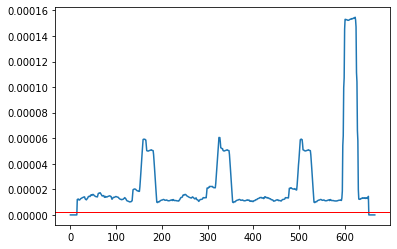

100%|██████████| 117/117 [00:00<00:00, 468257.22it/s]

(117, 30, 56)


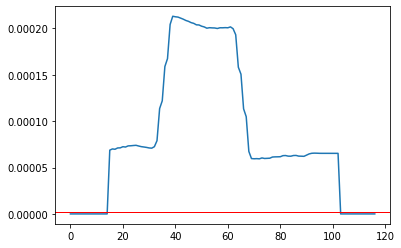

100%|██████████| 141/141 [00:00<00:00, 558976.24it/s]


(141, 30, 56)


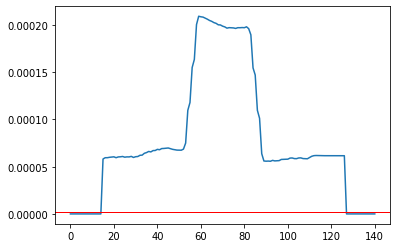

100%|██████████| 3901/3901 [00:00<00:00, 1133729.21it/s]


(3901, 30, 56)


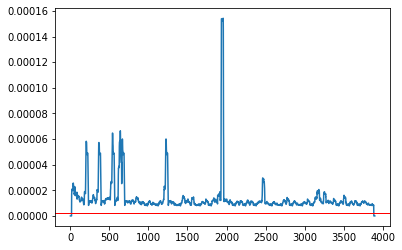

100%|██████████| 835/835 [00:00<00:00, 633202.65it/s]


(835, 30, 56)


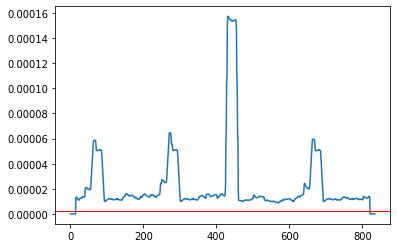

100%|██████████| 1301/1301 [00:00<00:00, 555115.92it/s]


(1301, 30, 56)


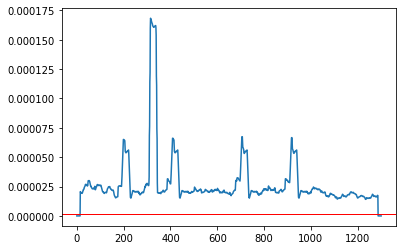

100%|██████████| 1245/1245 [00:00<00:00, 696904.91it/s]


(1245, 30, 56)


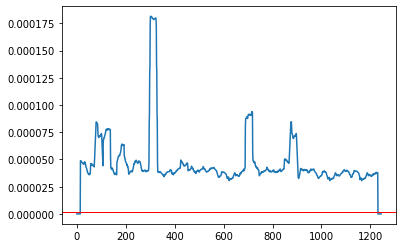

100%|██████████| 379/379 [00:00<00:00, 513284.22it/s]


(379, 30, 56)


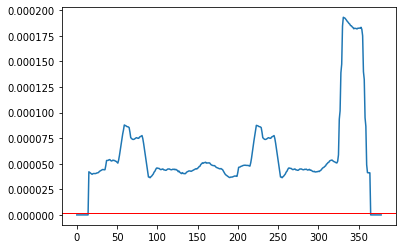

100%|██████████| 3499/3499 [00:00<00:00, 773024.48it/s]


(3499, 30, 56)


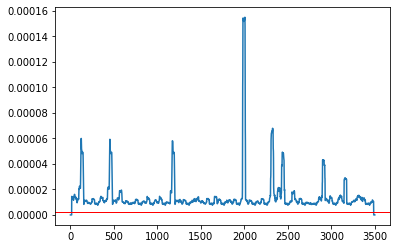

100%|██████████| 1345/1345 [00:00<00:00, 747395.19it/s]


(1345, 30, 56)


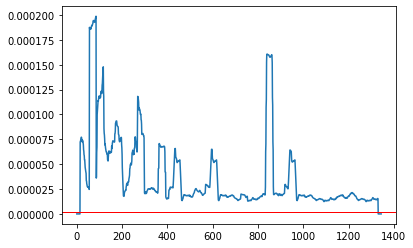

100%|██████████| 111/111 [00:00<00:00, 483455.60it/s]


(111, 30, 56)


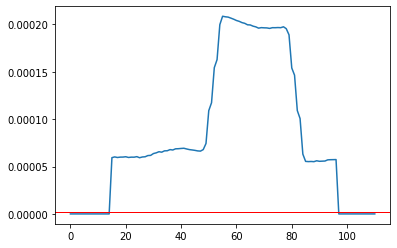

100%|██████████| 3927/3927 [00:00<00:00, 924404.07it/s]


(3927, 30, 56)


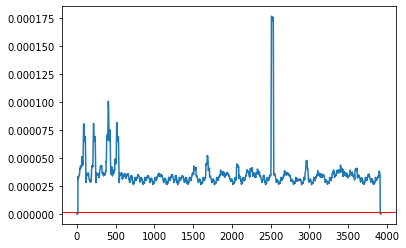

100%|██████████| 3007/3007 [00:00<00:00, 823255.36it/s]


(3007, 30, 56)


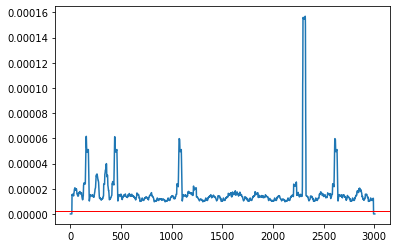

100%|██████████| 91/91 [00:00<00:00, 176377.85it/s]

(91, 30, 56)


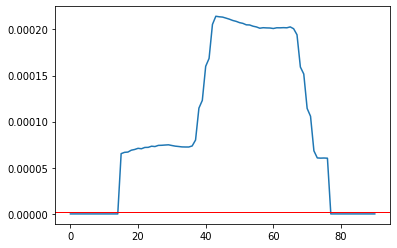

100%|██████████| 1361/1361 [00:00<00:00, 760619.29it/s]


(1361, 30, 56)


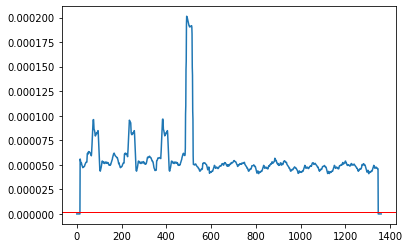

100%|██████████| 3707/3707 [00:00<00:00, 1108849.30it/s]


(3707, 30, 56)


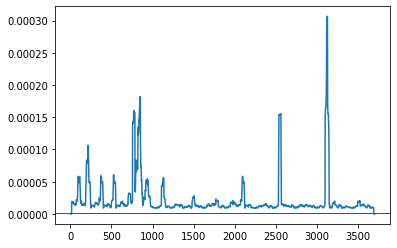

100%|██████████| 3571/3571 [00:00<00:00, 770267.91it/s]


(3571, 30, 56)


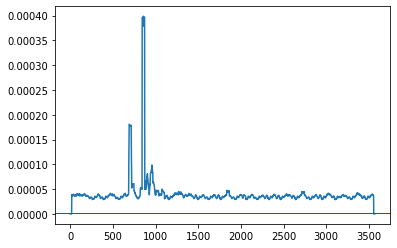

100%|██████████| 121/121 [00:00<00:00, 373994.68it/s]


(121, 30, 56)


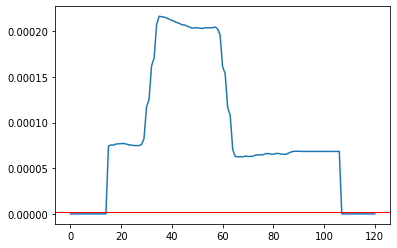

100%|██████████| 3741/3741 [00:00<00:00, 899397.64it/s]


(3741, 30, 56)


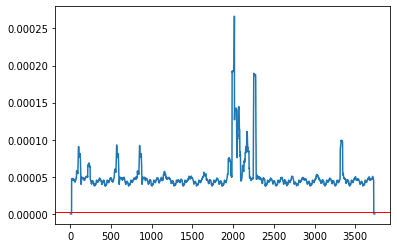

100%|██████████| 881/881 [00:00<00:00, 719466.87it/s]


(881, 30, 56)


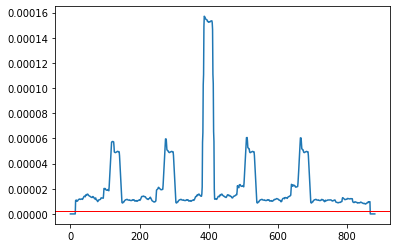

100%|██████████| 1449/1449 [00:00<00:00, 569165.25it/s]


(1449, 30, 56)


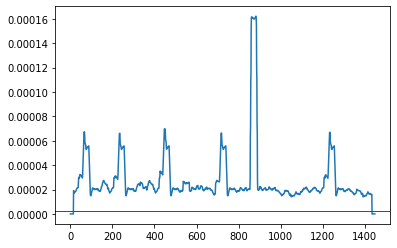

100%|██████████| 283/283 [00:00<00:00, 456533.86it/s]


(283, 30, 56)


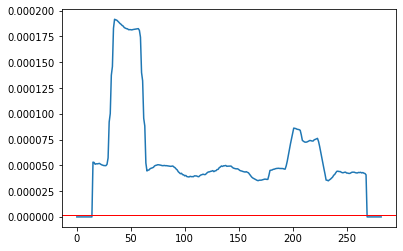

100%|██████████| 2251/2251 [00:00<00:00, 685648.39it/s]


(2251, 30, 56)


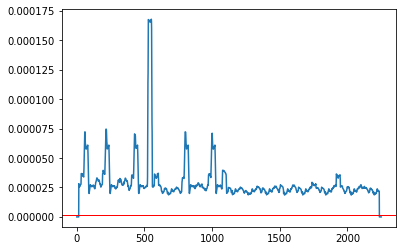

100%|██████████| 1943/1943 [00:00<00:00, 841198.67it/s]


(1943, 30, 56)


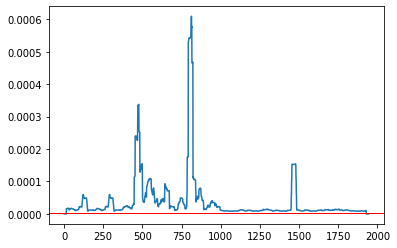

100%|██████████| 2614/2614 [00:00<00:00, 688601.35it/s]


(2614, 30, 56)


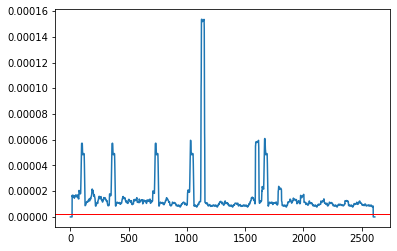

100%|██████████| 83/83 [00:00<00:00, 404799.11it/s]

(83, 30, 56)


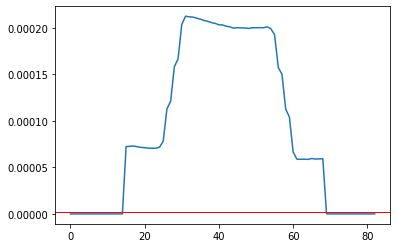

100%|██████████| 1341/1341 [00:00<00:00, 694819.23it/s]


(1341, 30, 56)


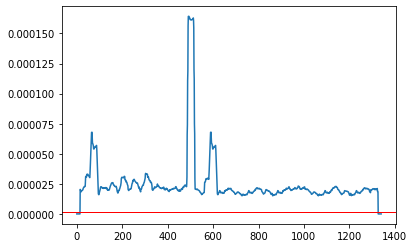

100%|██████████| 2267/2267 [00:00<00:00, 727671.78it/s]


(2267, 30, 56)


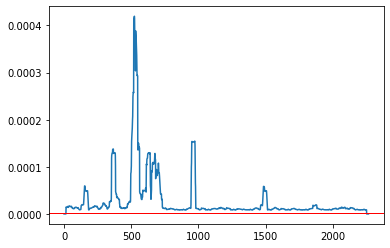

100%|██████████| 1849/1849 [00:00<00:00, 716686.82it/s]


(1849, 30, 56)


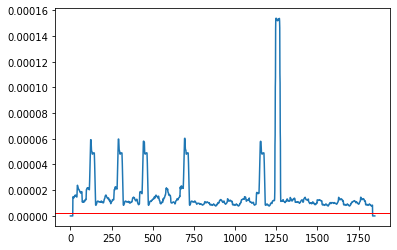

100%|██████████| 1337/1337 [00:00<00:00, 748702.86it/s]


(1337, 30, 56)


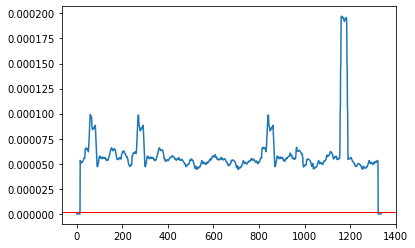

100%|██████████| 561/561 [00:00<00:00, 658735.87it/s]


(561, 30, 56)


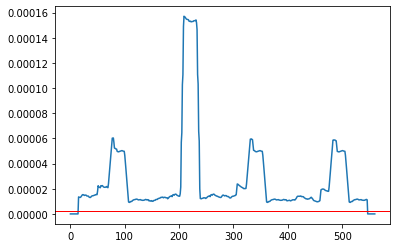

100%|██████████| 1667/1667 [00:00<00:00, 813106.73it/s]


(1667, 30, 56)


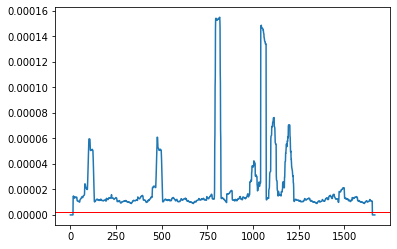

100%|██████████| 99/99 [00:00<00:00, 422417.19it/s]

(99, 30, 56)


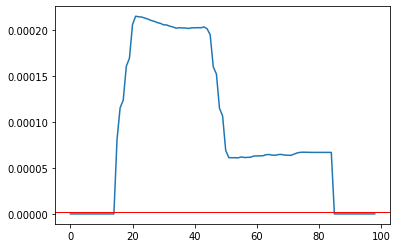

100%|██████████| 3097/3097 [00:00<00:00, 838969.16it/s]


(3097, 30, 56)


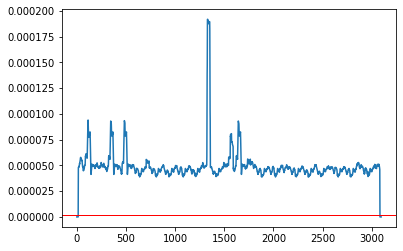

100%|██████████| 129/129 [00:00<00:00, 387028.05it/s]


(129, 30, 56)


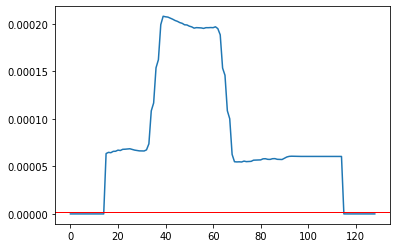

100%|██████████| 1379/1379 [00:00<00:00, 1095029.39it/s]


(1379, 30, 56)


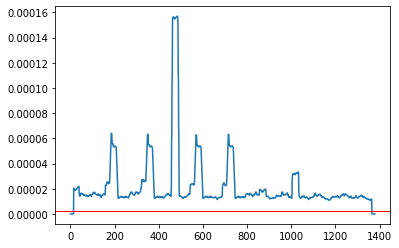

100%|██████████| 1495/1495 [00:00<00:00, 726423.13it/s]


(1495, 30, 56)


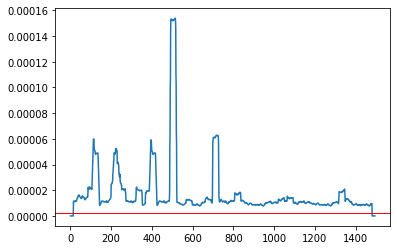

100%|██████████| 4421/4421 [00:00<00:00, 970787.81it/s]


(4421, 30, 56)


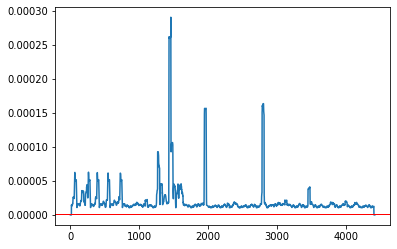

100%|██████████| 637/637 [00:00<00:00, 694327.35it/s]


(637, 30, 56)


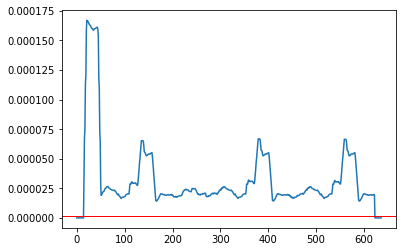

100%|██████████| 1223/1223 [00:00<00:00, 796403.32it/s]


(1223, 30, 56)


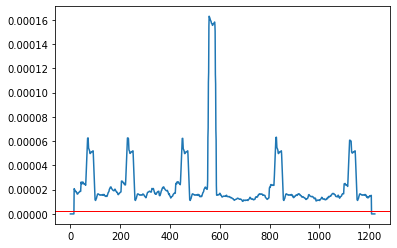

100%|██████████| 391/391 [00:00<00:00, 681617.98it/s]


(391, 30, 56)


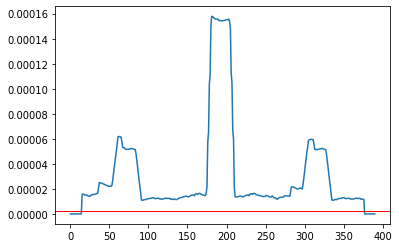

100%|██████████| 123/123 [00:00<00:00, 428487.87it/s]


(123, 30, 56)


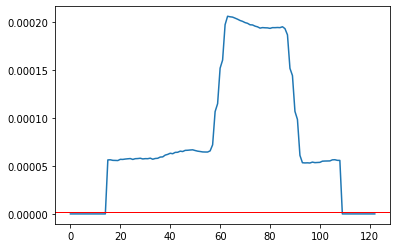

100%|██████████| 133/133 [00:00<00:00, 309396.80it/s]

(133, 30, 56)


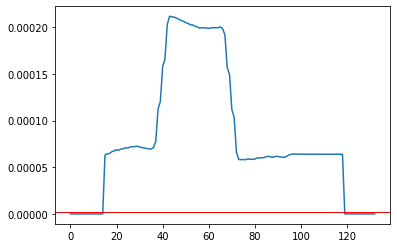

100%|██████████| 1767/1767 [00:00<00:00, 709626.12it/s]


(1767, 30, 56)


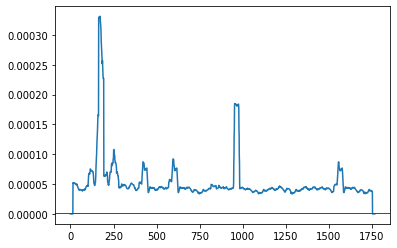

100%|██████████| 2111/2111 [00:00<00:00, 820514.85it/s]


(2111, 30, 56)


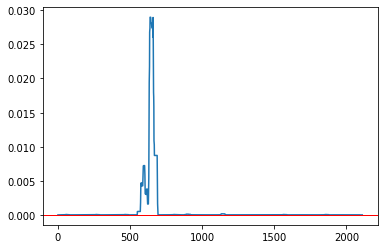

100%|██████████| 115/115 [00:00<00:00, 295192.75it/s]


(115, 30, 56)


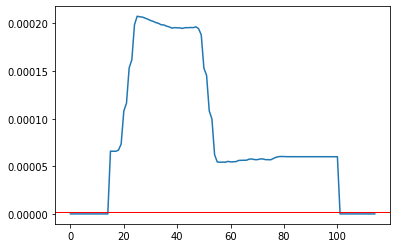

100%|██████████| 3409/3409 [00:00<00:00, 838565.62it/s]


(3409, 30, 56)


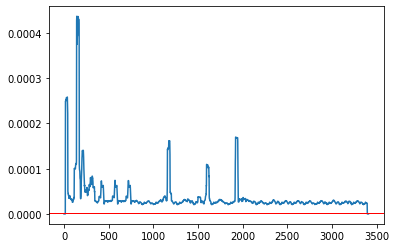

100%|██████████| 1779/1779 [00:00<00:00, 776125.11it/s]


(1779, 30, 56)


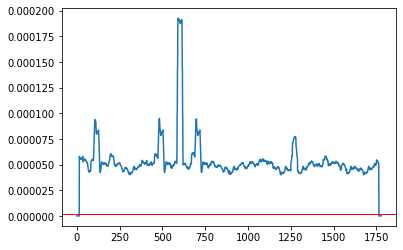

100%|██████████| 85/85 [00:00<00:00, 122894.12it/s]

(85, 30, 56)


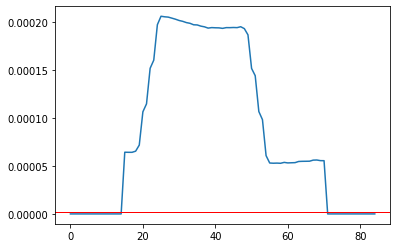

100%|██████████| 121/121 [00:00<00:00, 152910.75it/s]


(121, 30, 56)


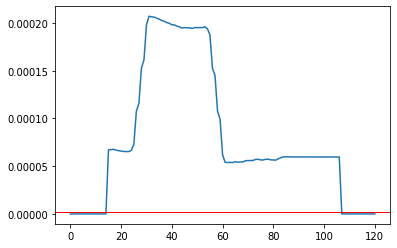

100%|██████████| 3255/3255 [00:00<00:00, 759186.98it/s]


(3255, 30, 56)


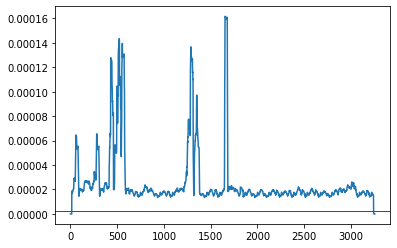

100%|██████████| 129/129 [00:00<00:00, 269320.67it/s]

(129, 30, 56)


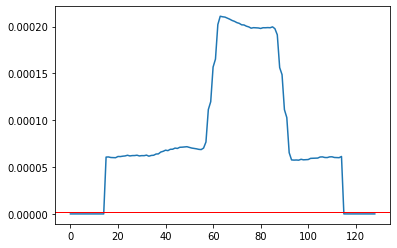

100%|██████████| 2081/2081 [00:00<00:00, 664308.29it/s]


(2081, 30, 56)


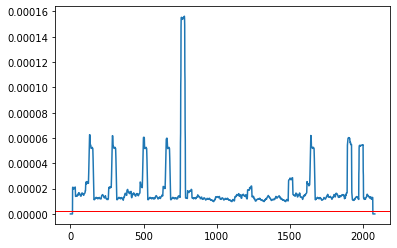

100%|██████████| 897/897 [00:00<00:00, 717173.22it/s]


(897, 30, 56)


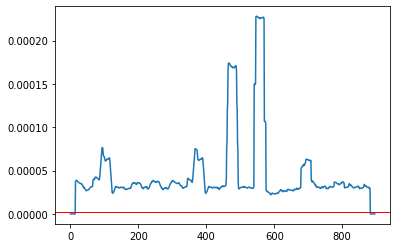

100%|██████████| 1541/1541 [00:00<00:00, 826947.60it/s]


(1541, 30, 56)


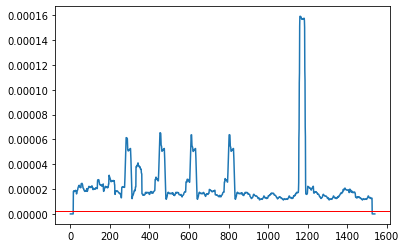

100%|██████████| 99/99 [00:00<00:00, 323140.93it/s]


(99, 30, 56)


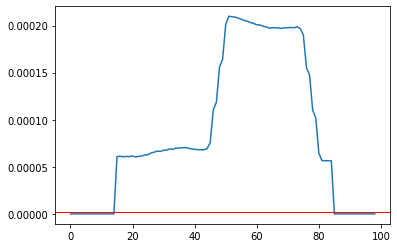

100%|██████████| 865/865 [00:00<00:00, 697036.11it/s]


(865, 30, 56)


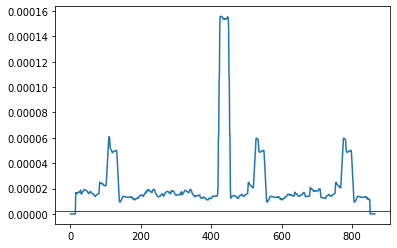

100%|██████████| 903/903 [00:00<00:00, 789217.86it/s]


(903, 30, 56)


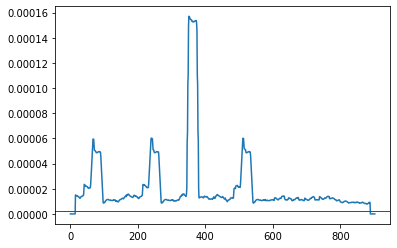

100%|██████████| 3705/3705 [00:00<00:00, 768845.06it/s]


(3705, 30, 56)


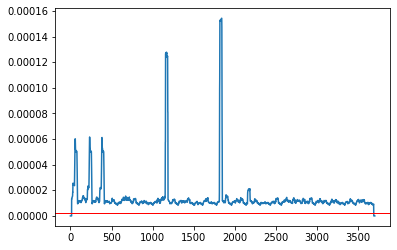

100%|██████████| 751/751 [00:00<00:00, 466724.30it/s]


(751, 30, 56)


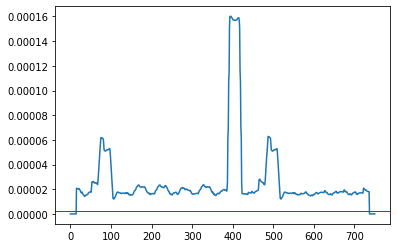

100%|██████████| 965/965 [00:00<00:00, 567036.05it/s]


(965, 30, 56)


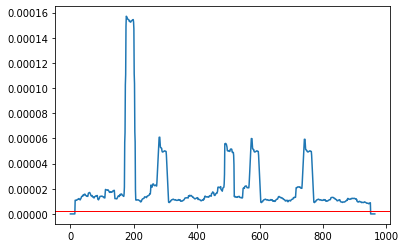

100%|██████████| 1473/1473 [00:00<00:00, 956527.29it/s]


(1473, 30, 56)


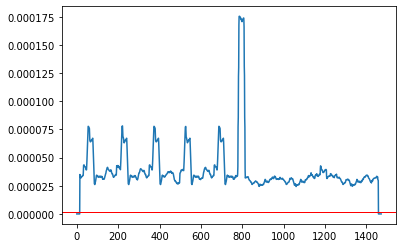

100%|██████████| 91/91 [00:00<00:00, 576558.40it/s]

(91, 30, 56)


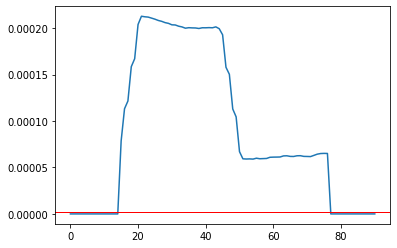

100%|██████████| 4175/4175 [00:00<00:00, 698799.60it/s]


(4175, 30, 56)


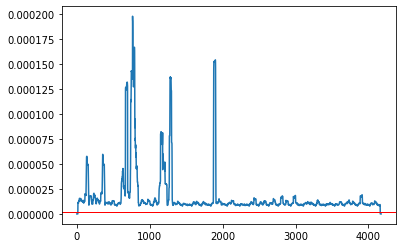

100%|██████████| 1953/1953 [00:00<00:00, 1357553.15it/s]


(1953, 30, 56)


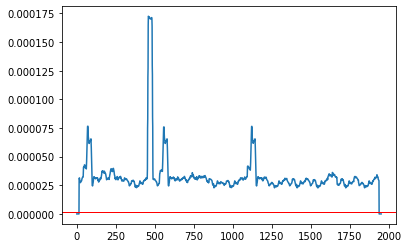

100%|██████████| 3271/3271 [00:00<00:00, 980389.34it/s]


(3271, 30, 56)


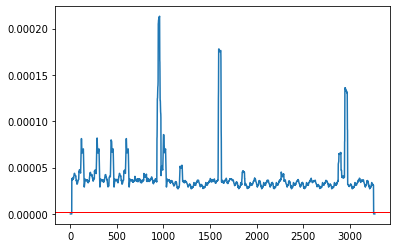

100%|██████████| 1901/1901 [00:00<00:00, 873889.95it/s]


(1901, 30, 56)


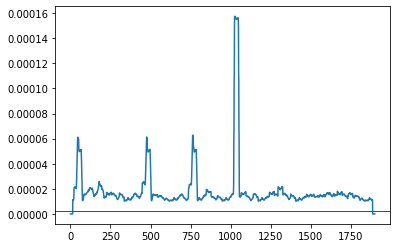

100%|██████████| 1861/1861 [00:00<00:00, 609764.84it/s]


(1861, 30, 56)


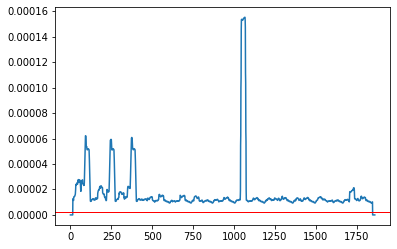

100%|██████████| 1715/1715 [00:00<00:00, 1365457.74it/s]


(1715, 30, 56)


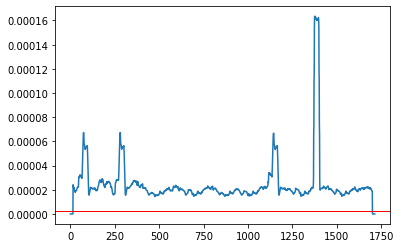

100%|██████████| 823/823 [00:00<00:00, 702750.85it/s]


(823, 30, 56)


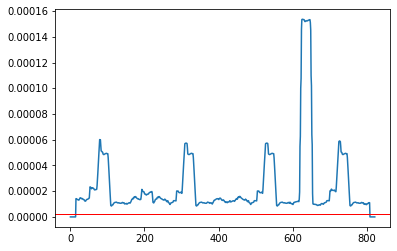

100%|██████████| 167/167 [00:00<00:00, 611745.65it/s]


(167, 30, 56)


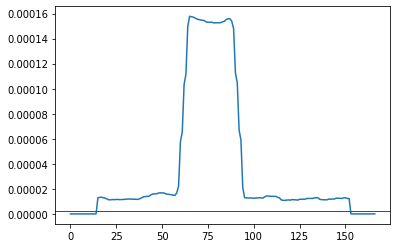

100%|██████████| 1233/1233 [00:00<00:00, 604438.62it/s]


(1233, 30, 56)


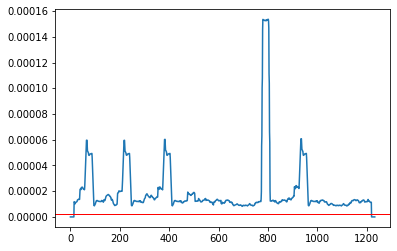

100%|██████████| 3195/3195 [00:00<00:00, 927712.10it/s]


(3195, 30, 56)


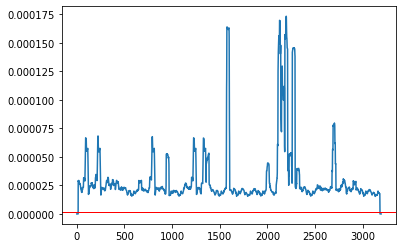

100%|██████████| 1471/1471 [00:00<00:00, 1087576.45it/s]


(1471, 30, 56)


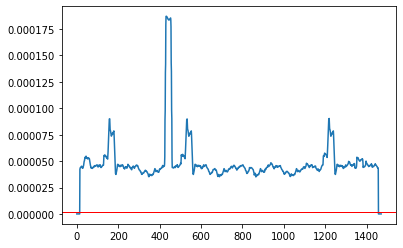

100%|██████████| 3437/3437 [00:00<00:00, 810378.48it/s]


(3437, 30, 56)


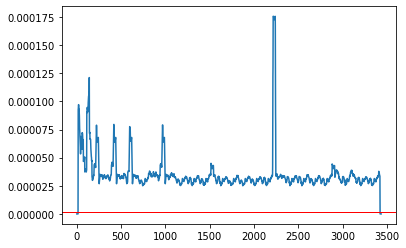

100%|██████████| 575/575 [00:00<00:00, 665854.45it/s]


(575, 30, 56)


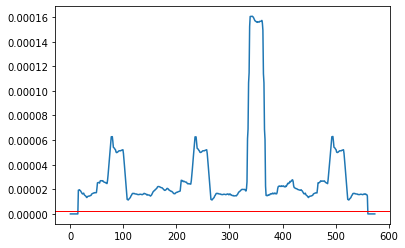

100%|██████████| 2995/2995 [00:00<00:00, 701079.39it/s]


(2995, 30, 56)


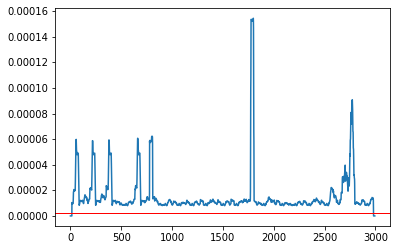

100%|██████████| 371/371 [00:00<00:00, 585215.04it/s]


(371, 30, 56)


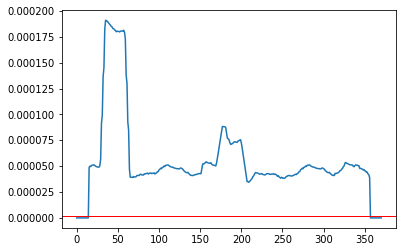

100%|██████████| 105/105 [00:00<00:00, 697942.82it/s]


(105, 30, 56)


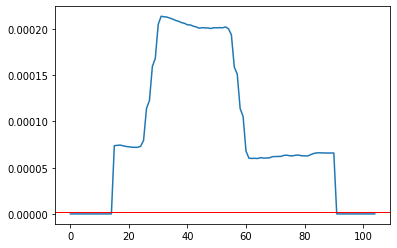

100%|██████████| 1123/1123 [00:00<00:00, 989538.53it/s]


(1123, 30, 56)


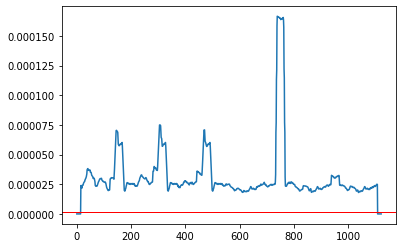

100%|██████████| 903/903 [00:00<00:00, 612460.63it/s]


(903, 30, 56)


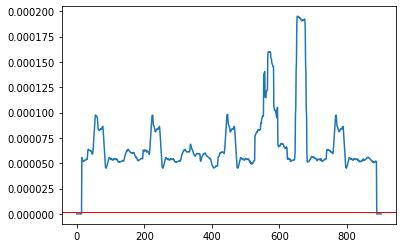

100%|██████████| 4141/4141 [00:00<00:00, 892528.92it/s]


(4141, 30, 56)


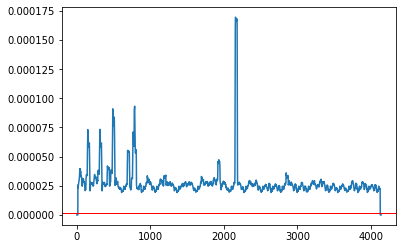

100%|██████████| 145/145 [00:00<00:00, 476999.28it/s]


(145, 30, 56)


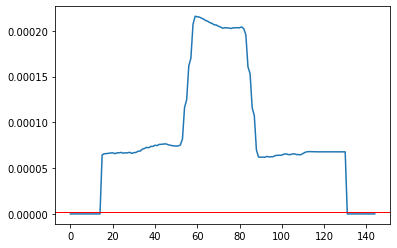

100%|██████████| 975/975 [00:00<00:00, 728956.58it/s]


(975, 30, 56)


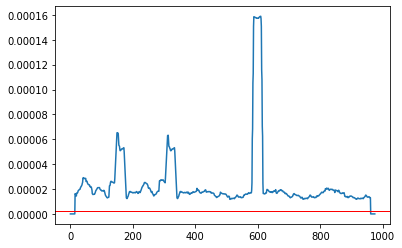

100%|██████████| 275/275 [00:00<00:00, 586989.11it/s]


(275, 30, 56)


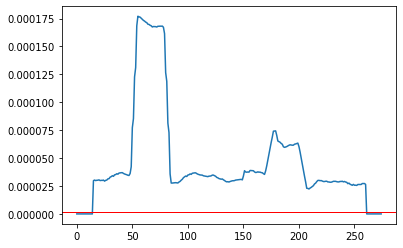

100%|██████████| 103/103 [00:00<00:00, 460568.56it/s]

(103, 30, 56)


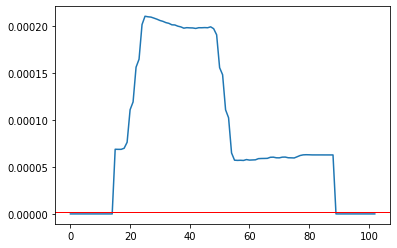

100%|██████████| 995/995 [00:00<00:00, 575711.47it/s]


(995, 30, 56)


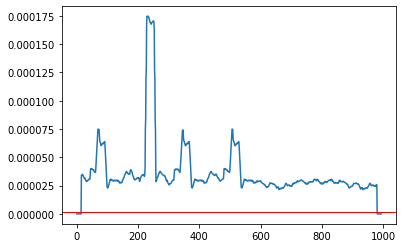

100%|██████████| 109/109 [00:00<00:00, 492649.93it/s]

(109, 30, 56)


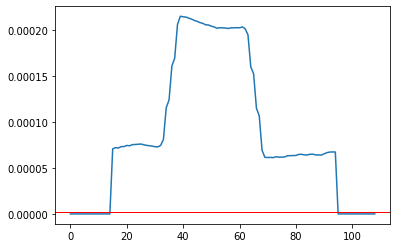

100%|██████████| 1621/1621 [00:00<00:00, 848280.32it/s]


(1621, 30, 56)


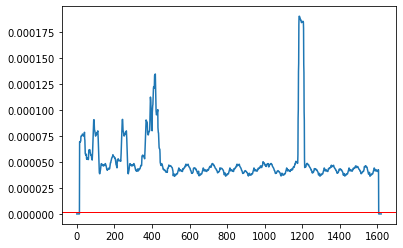

100%|██████████| 1165/1165 [00:00<00:00, 699050.67it/s]


(1165, 30, 56)


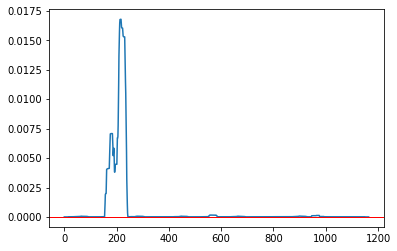

100%|██████████| 931/931 [00:00<00:00, 667732.05it/s]


(931, 30, 56)


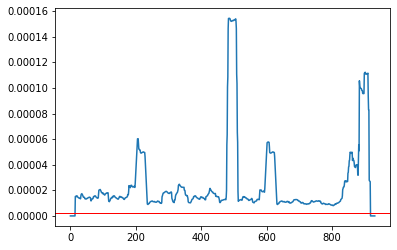

100%|██████████| 1445/1445 [00:00<00:00, 594601.13it/s]


(1445, 30, 56)


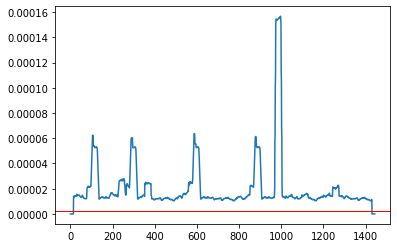

100%|██████████| 2507/2507 [00:00<00:00, 778494.12it/s]


(2507, 30, 56)


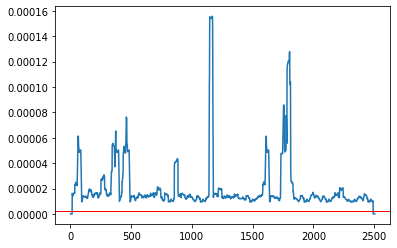

100%|██████████| 899/899 [00:00<00:00, 737469.06it/s]


(899, 30, 56)


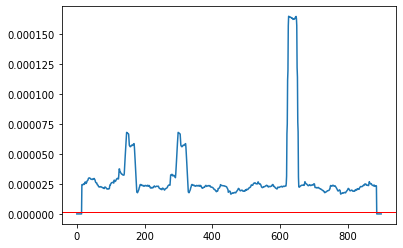

100%|██████████| 3141/3141 [00:00<00:00, 907634.09it/s]


(3141, 30, 56)


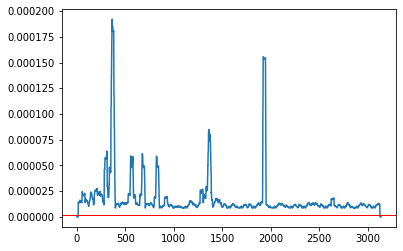

100%|██████████| 1559/1559 [00:00<00:00, 857563.27it/s]


(1559, 30, 56)


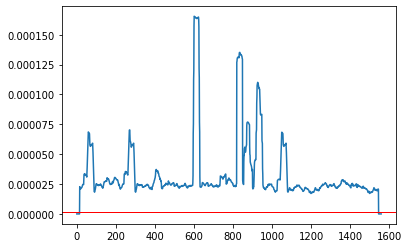

100%|██████████| 2011/2011 [00:00<00:00, 762083.97it/s]


(2011, 30, 56)


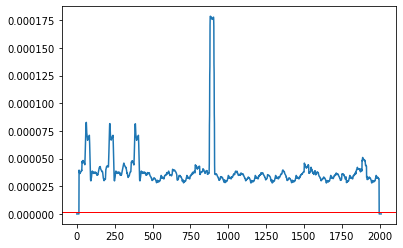

100%|██████████| 1033/1033 [00:00<00:00, 436413.78it/s]


(1033, 30, 56)


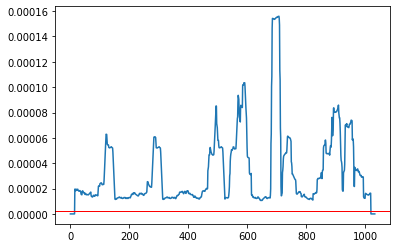

100%|██████████| 1695/1695 [00:00<00:00, 815572.48it/s]


(1695, 30, 56)


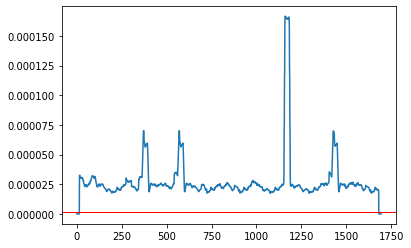

100%|██████████| 2437/2437 [00:00<00:00, 1179088.57it/s]


(2437, 30, 56)


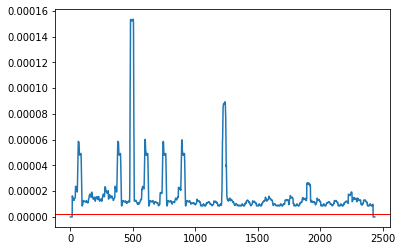

100%|██████████| 689/689 [00:00<00:00, 680130.73it/s]


(689, 30, 56)


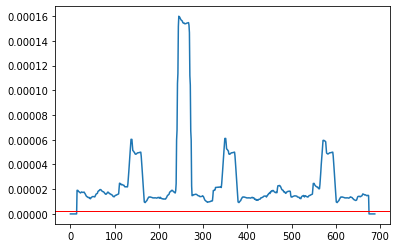

100%|██████████| 2197/2197 [00:00<00:00, 864030.56it/s]


(2197, 30, 56)


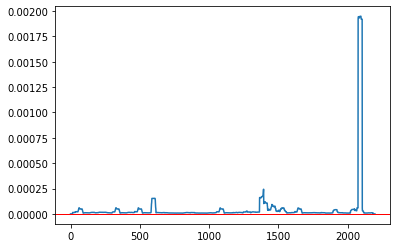

100%|██████████| 1507/1507 [00:00<00:00, 798587.00it/s]


(1507, 30, 56)


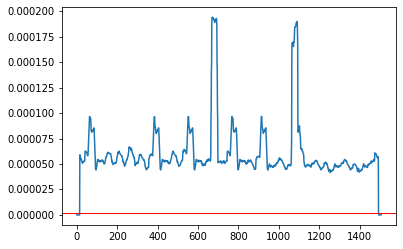

100%|██████████| 1785/1785 [00:00<00:00, 1171648.30it/s]


(1785, 30, 56)


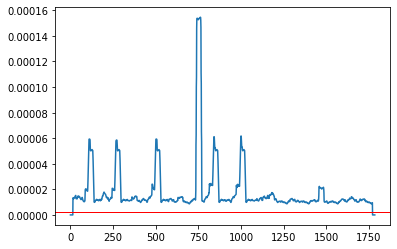

100%|██████████| 1067/1067 [00:00<00:00, 636875.25it/s]


(1067, 30, 56)


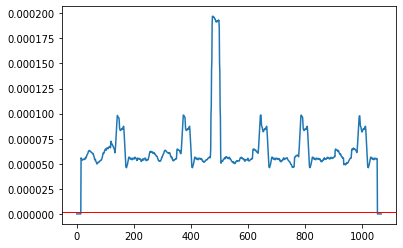

100%|██████████| 2387/2387 [00:00<00:00, 777676.22it/s]


(2387, 30, 56)


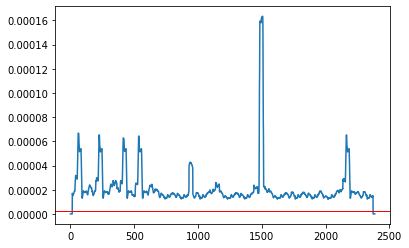

100%|██████████| 2133/2133 [00:00<00:00, 632168.63it/s]


(2133, 30, 56)


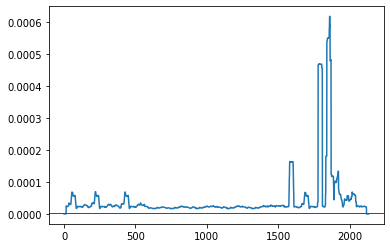

100%|██████████| 3543/3543 [00:00<00:00, 865185.09it/s]


(3543, 30, 56)


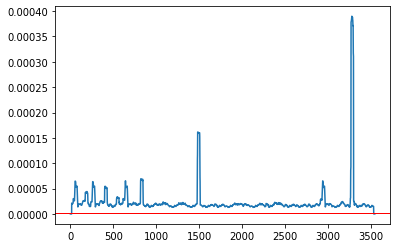

100%|██████████| 1623/1623 [00:00<00:00, 1197634.66it/s]


(1623, 30, 56)


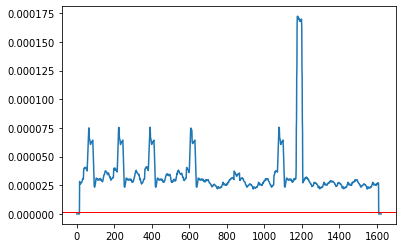

100%|██████████| 988/988 [00:00<00:00, 633925.71it/s]


(988, 30, 56)


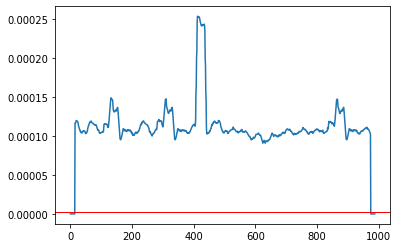

100%|██████████| 1721/1721 [00:00<00:00, 892813.50it/s]


(1721, 30, 56)


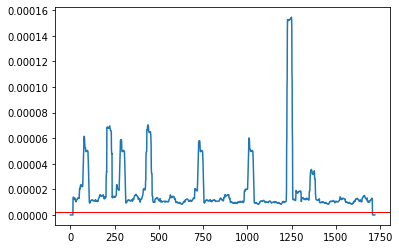

100%|██████████| 701/701 [00:00<00:00, 685522.76it/s]


(701, 30, 56)


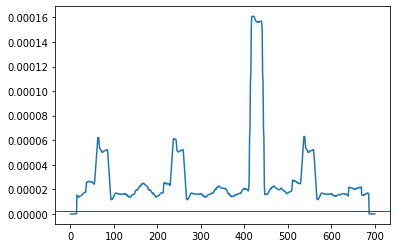

100%|██████████| 5704/5704 [00:00<00:00, 756763.14it/s]


(5704, 30, 56)


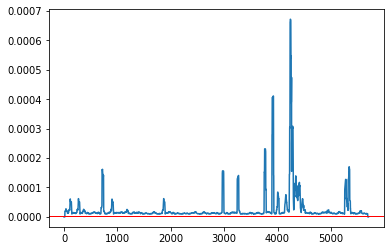

100%|██████████| 2115/2115 [00:00<00:00, 736545.41it/s]


(2115, 30, 56)


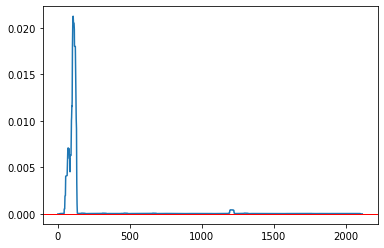

100%|██████████| 2947/2947 [00:00<00:00, 673309.40it/s]


(2947, 30, 56)


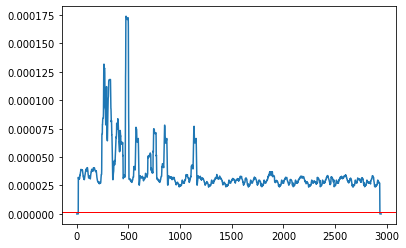

100%|██████████| 1795/1795 [00:00<00:00, 677596.59it/s]


(1795, 30, 56)


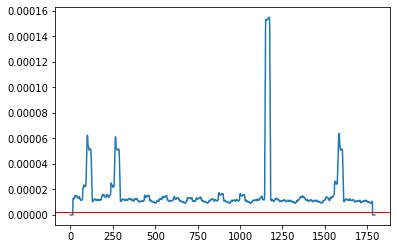

100%|██████████| 3727/3727 [00:00<00:00, 718588.35it/s]


(3727, 30, 56)


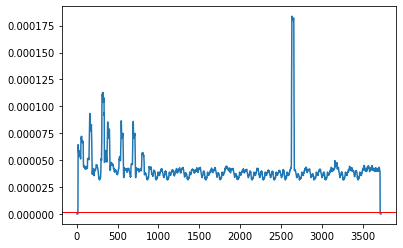

100%|██████████| 1113/1113 [00:00<00:00, 855776.42it/s]


(1113, 30, 56)


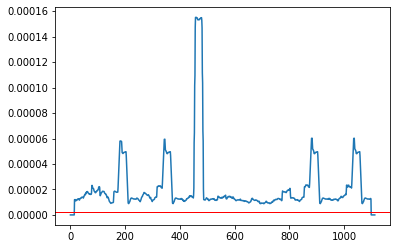

100%|██████████| 1889/1889 [00:00<00:00, 823600.86it/s]


(1889, 30, 56)


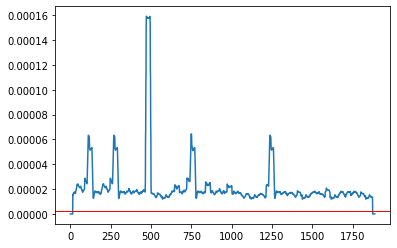

100%|██████████| 1113/1113 [00:00<00:00, 897915.05it/s]


(1113, 30, 56)


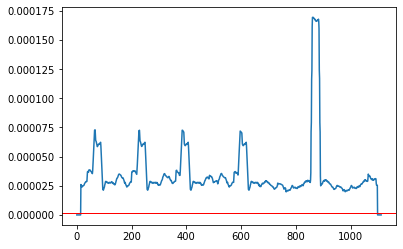

100%|██████████| 1287/1287 [00:00<00:00, 1067656.10it/s]


(1287, 30, 56)


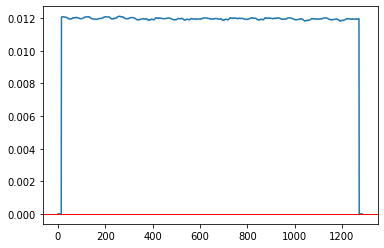

100%|██████████| 1407/1407 [00:00<00:00, 1245280.80it/s]


(1407, 30, 56)


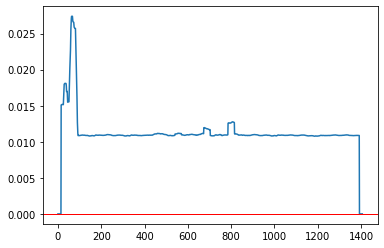

100%|██████████| 159/159 [00:00<00:00, 216173.20it/s]


(159, 30, 56)


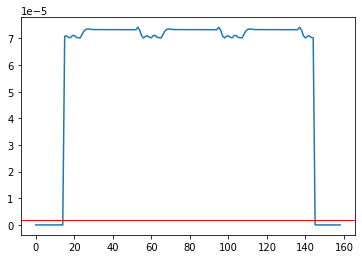

100%|██████████| 159/159 [00:00<00:00, 519792.94it/s]


(159, 30, 56)


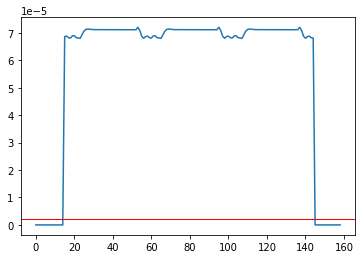

100%|██████████| 159/159 [00:00<00:00, 129897.61it/s]


(159, 30, 56)


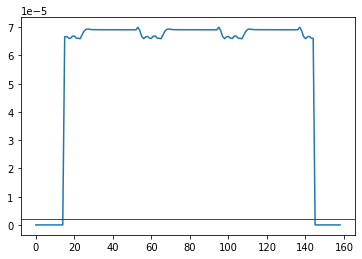

100%|██████████| 1093/1093 [00:00<00:00, 905823.80it/s]


(1093, 30, 56)


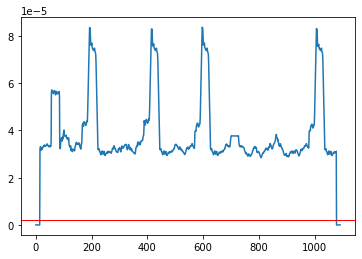

100%|██████████| 727/727 [00:00<00:00, 693959.72it/s]


(727, 30, 56)


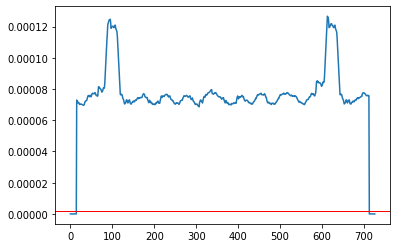

100%|██████████| 1289/1289 [00:00<00:00, 1088694.70it/s]


(1289, 30, 56)


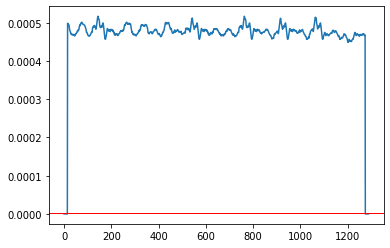

100%|██████████| 905/905 [00:00<00:00, 710034.63it/s]


(905, 30, 56)


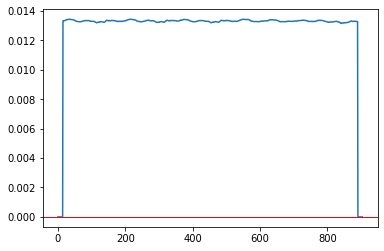

100%|██████████| 2725/2725 [00:00<00:00, 796756.95it/s]


(2725, 30, 56)


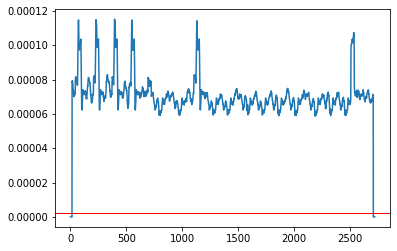

100%|██████████| 4085/4085 [00:00<00:00, 902725.60it/s]


(4085, 30, 56)


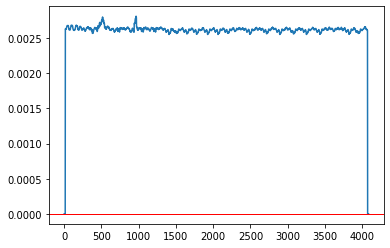

100%|██████████| 1765/1765 [00:00<00:00, 1157976.94it/s]


(1765, 30, 56)


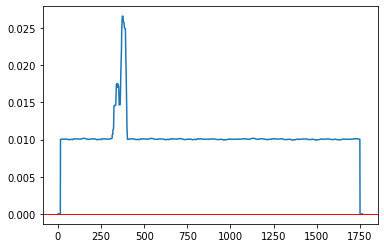

100%|██████████| 4921/4921 [00:00<00:00, 669635.34it/s]


(4921, 30, 56)


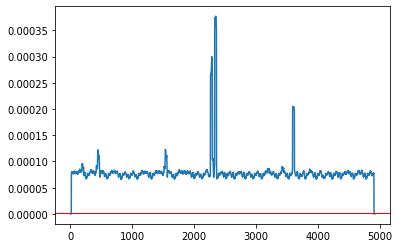

100%|██████████| 4067/4067 [00:00<00:00, 753821.84it/s]


(4067, 30, 56)


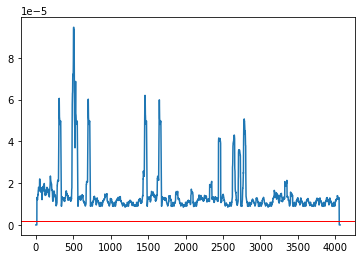

100%|██████████| 3575/3575 [00:00<00:00, 750670.18it/s]


(3575, 30, 56)


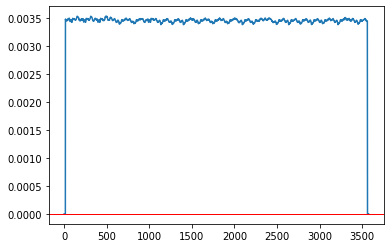

100%|██████████| 1615/1615 [00:00<00:00, 761700.32it/s]


(1615, 30, 56)


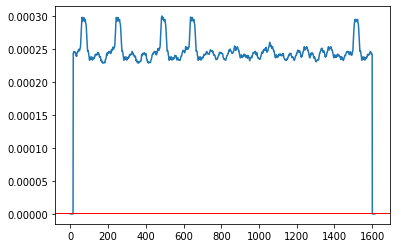

100%|██████████| 4323/4323 [00:00<00:00, 1259864.94it/s]


(4323, 30, 56)


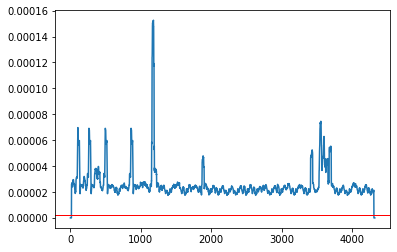

100%|██████████| 2621/2621 [00:00<00:00, 789633.01it/s]


(2621, 30, 56)


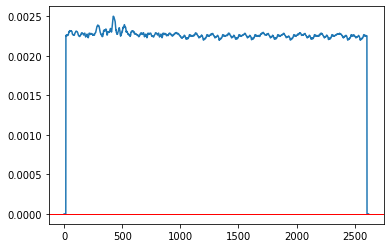

100%|██████████| 1867/1867 [00:00<00:00, 771960.33it/s]


(1867, 30, 56)


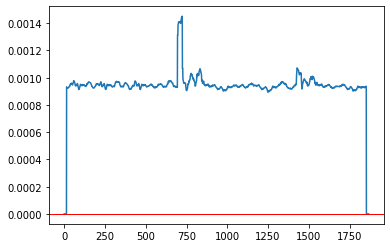

100%|██████████| 1089/1089 [00:00<00:00, 658914.75it/s]


(1089, 30, 56)


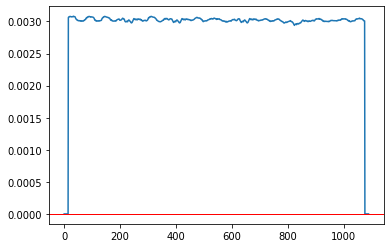

100%|██████████| 8121/8121 [00:00<00:00, 676920.11it/s]


(8121, 30, 56)


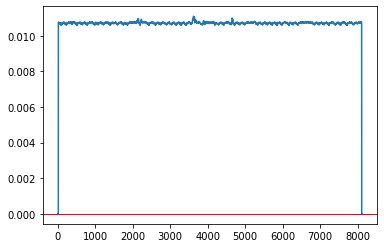

100%|██████████| 2828/2828 [00:00<00:00, 875580.70it/s]


(2828, 30, 56)


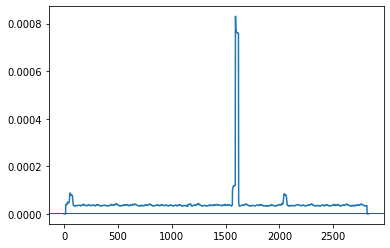

100%|██████████| 2377/2377 [00:00<00:00, 824091.64it/s]


(2377, 30, 56)


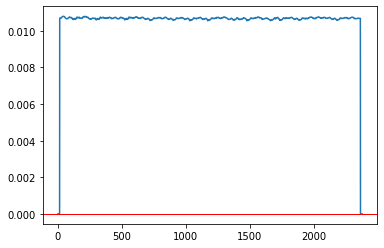

100%|██████████| 4703/4703 [00:00<00:00, 1072929.66it/s]


(4703, 30, 56)


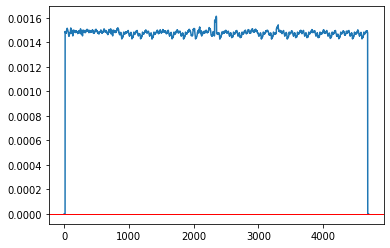

100%|██████████| 2391/2391 [00:00<00:00, 755334.85it/s]


(2391, 30, 56)


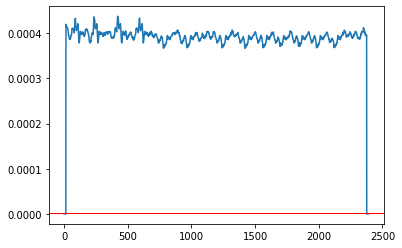

100%|██████████| 3707/3707 [00:00<00:00, 857836.41it/s]


(3707, 30, 56)


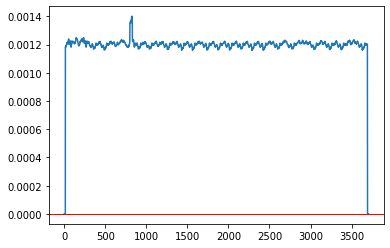

100%|██████████| 4552/4552 [00:00<00:00, 956584.59it/s]


(4552, 30, 56)


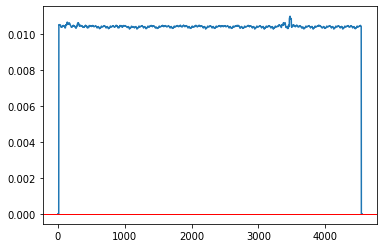

100%|██████████| 5835/5835 [00:00<00:00, 1229899.18it/s]


(5835, 30, 56)


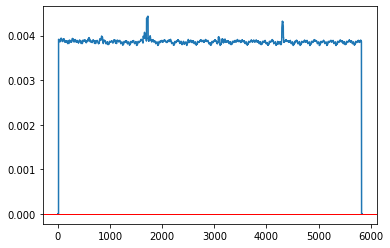

100%|██████████| 3549/3549 [00:00<00:00, 1372829.00it/s]


(3549, 30, 56)


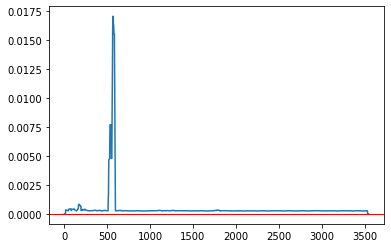

100%|██████████| 7199/7199 [00:00<00:00, 753081.29it/s]


(7199, 30, 56)


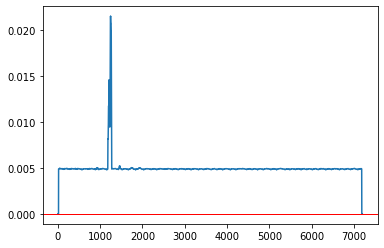

100%|██████████| 4803/4803 [00:00<00:00, 1098671.58it/s]


(4803, 30, 56)


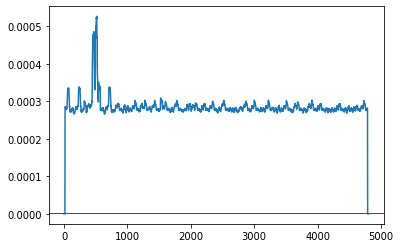

100%|██████████| 1767/1767 [00:00<00:00, 753337.59it/s]


(1767, 30, 56)


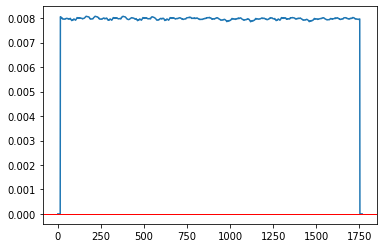

100%|██████████| 1219/1219 [00:00<00:00, 741961.48it/s]


(1219, 30, 56)


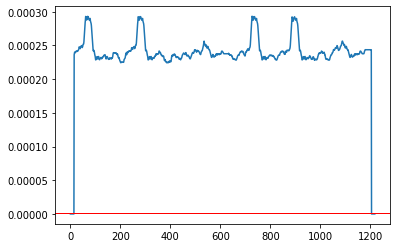

100%|██████████| 947/947 [00:00<00:00, 733925.70it/s]


(947, 30, 56)


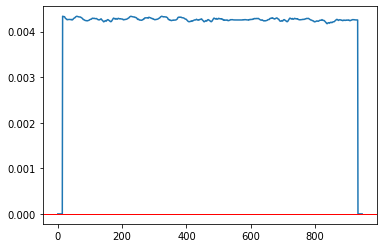

100%|██████████| 4229/4229 [00:00<00:00, 839257.71it/s]


(4229, 30, 56)


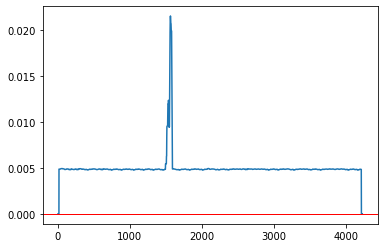

100%|██████████| 4499/4499 [00:00<00:00, 912616.61it/s]


(4499, 30, 56)


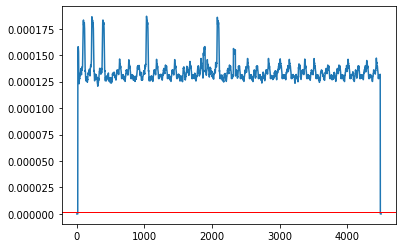

100%|██████████| 1633/1633 [00:00<00:00, 1022588.60it/s]


(1633, 30, 56)


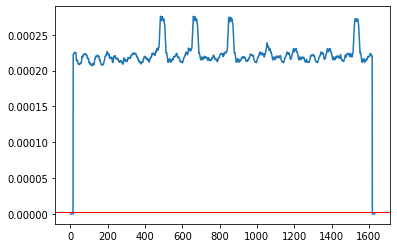

100%|██████████| 2889/2889 [00:00<00:00, 716409.14it/s]


(2889, 30, 56)


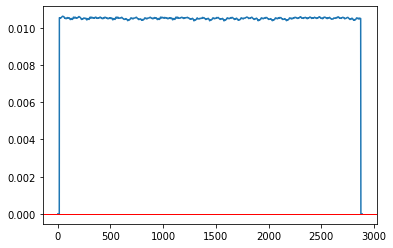

100%|██████████| 5367/5367 [00:00<00:00, 845477.17it/s]


(5367, 30, 56)


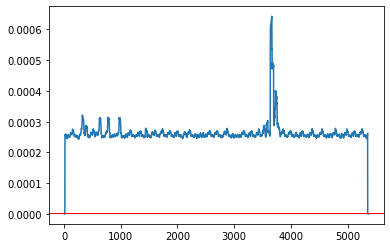

100%|██████████| 1025/1025 [00:00<00:00, 729660.83it/s]


(1025, 30, 56)


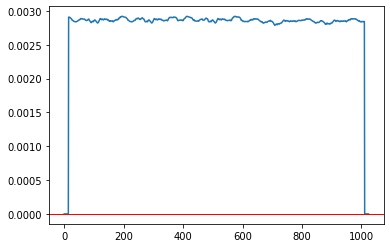

100%|██████████| 1899/1899 [00:00<00:00, 848783.39it/s]


(1899, 30, 56)


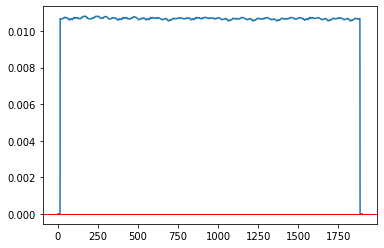

100%|██████████| 2181/2181 [00:00<00:00, 771899.17it/s]


(2181, 30, 56)


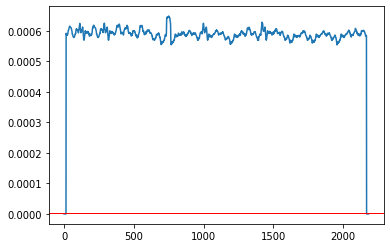

100%|██████████| 3635/3635 [00:00<00:00, 854852.54it/s]


(3635, 30, 56)


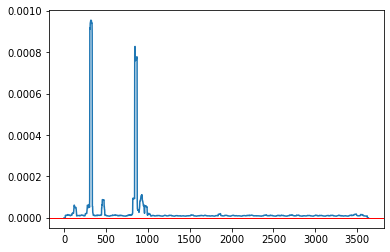

100%|██████████| 2739/2739 [00:00<00:00, 1087794.59it/s]


(2739, 30, 56)


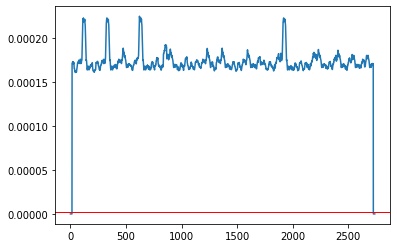

100%|██████████| 2416/2416 [00:00<00:00, 692884.68it/s]


(2416, 30, 56)


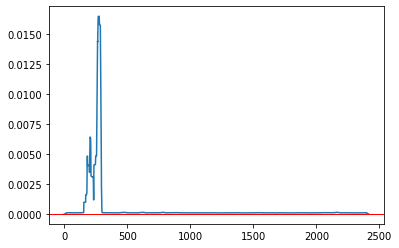

100%|██████████| 3921/3921 [00:00<00:00, 1082392.13it/s]


(3921, 30, 56)


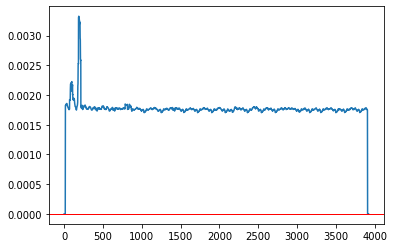

100%|██████████| 5159/5159 [00:00<00:00, 876333.00it/s]


(5159, 30, 56)


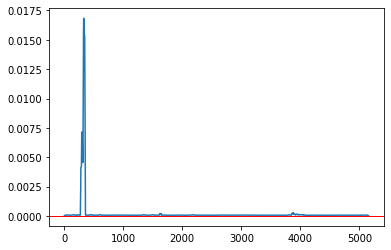

100%|██████████| 751/751 [00:00<00:00, 767337.95it/s]


(751, 30, 56)


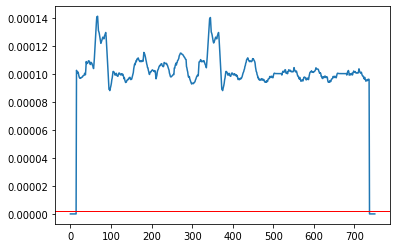

100%|██████████| 3721/3721 [00:00<00:00, 868406.70it/s]


(3721, 30, 56)


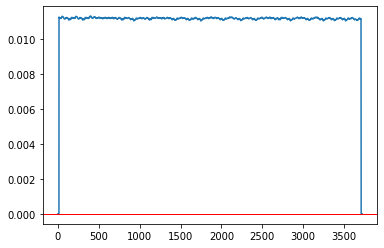

100%|██████████| 4369/4369 [00:00<00:00, 886160.56it/s]


(4369, 30, 56)


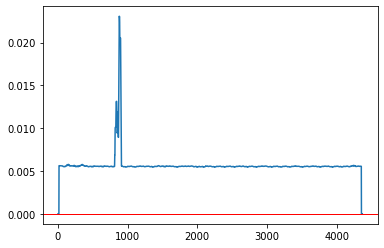

100%|██████████| 5971/5971 [00:00<00:00, 1222442.97it/s]


(5971, 30, 56)


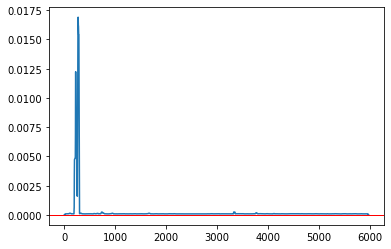

100%|██████████| 7071/7071 [00:00<00:00, 753236.24it/s]


(7071, 30, 56)


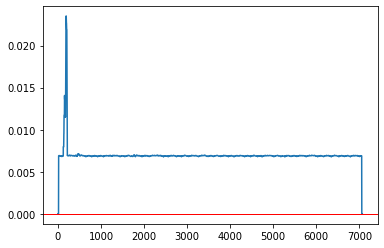

100%|██████████| 6995/6995 [00:00<00:00, 984667.62it/s]


(6995, 30, 56)


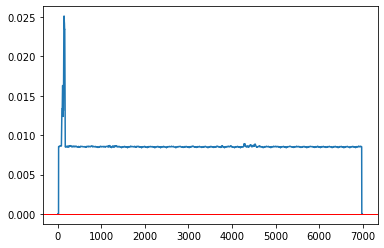

100%|██████████| 1619/1619 [00:00<00:00, 739875.59it/s]


(1619, 30, 56)


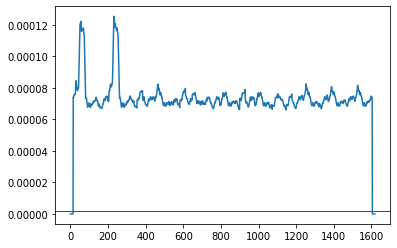

100%|██████████| 2435/2435 [00:00<00:00, 718728.38it/s]


(2435, 30, 56)


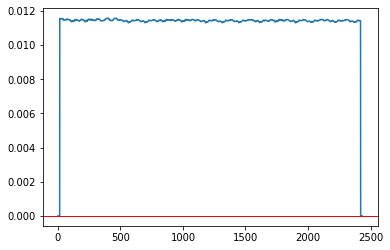

100%|██████████| 3303/3303 [00:00<00:00, 1077528.67it/s]


(3303, 30, 56)


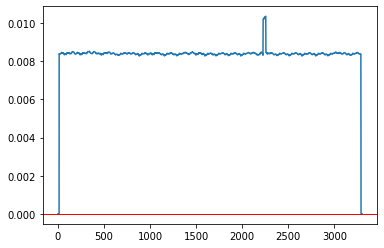

100%|██████████| 3315/3315 [00:00<00:00, 895595.35it/s]


(3315, 30, 56)


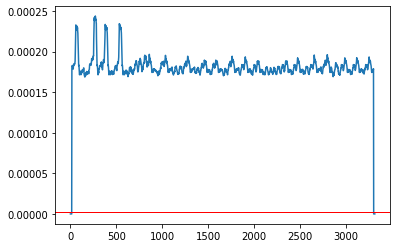

100%|██████████| 3933/3933 [00:00<00:00, 775598.18it/s]


(3933, 30, 56)


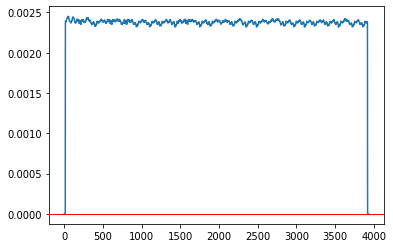

100%|██████████| 3401/3401 [00:00<00:00, 765567.97it/s]


(3401, 30, 56)


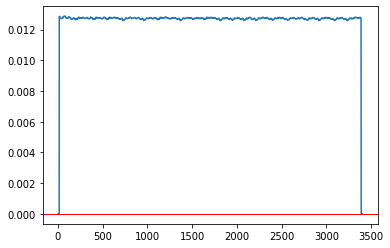

100%|██████████| 2651/2651 [00:00<00:00, 1333385.29it/s]


(2651, 30, 56)


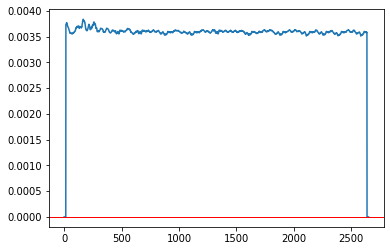

100%|██████████| 3117/3117 [00:00<00:00, 896929.58it/s]


(3117, 30, 56)


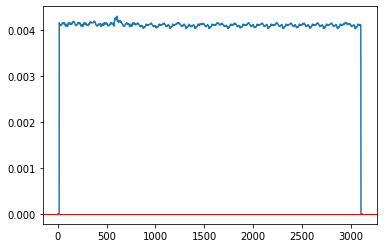

100%|██████████| 2929/2929 [00:00<00:00, 702809.86it/s]


(2929, 30, 56)


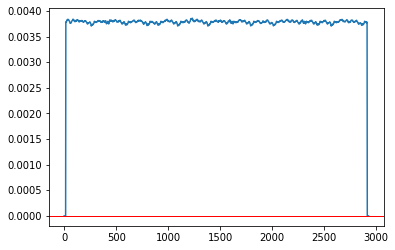

100%|██████████| 3059/3059 [00:00<00:00, 725700.00it/s]


(3059, 30, 56)


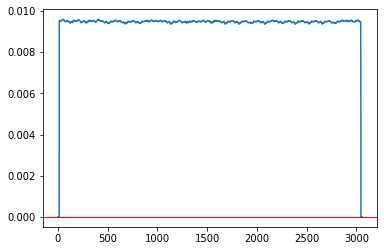

100%|██████████| 6095/6095 [00:00<00:00, 953926.75it/s]


(6095, 30, 56)


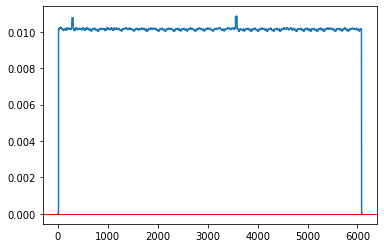

100%|██████████| 7939/7939 [00:00<00:00, 1037500.53it/s]


(7939, 30, 56)


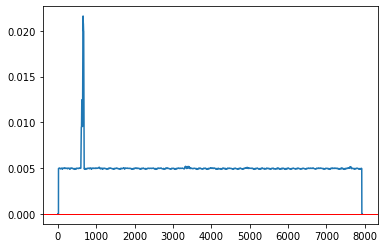

100%|██████████| 605/605 [00:00<00:00, 505388.15it/s]


(605, 30, 56)


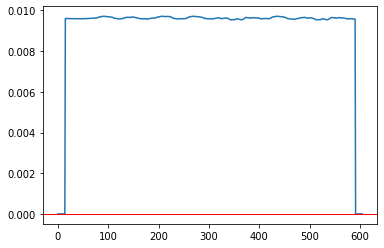

100%|██████████| 2835/2835 [00:00<00:00, 787630.11it/s]


(2835, 30, 56)


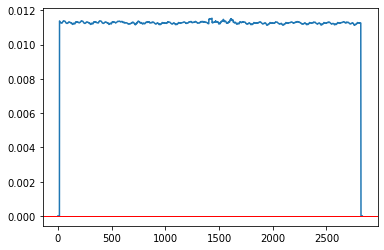

100%|██████████| 729/729 [00:00<00:00, 510288.32it/s]


(729, 30, 56)


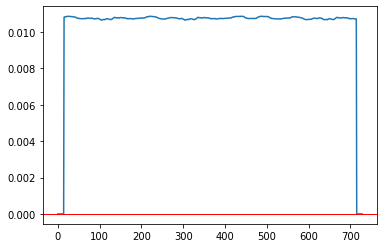

100%|██████████| 4123/4123 [00:00<00:00, 801832.22it/s]


(4123, 30, 56)


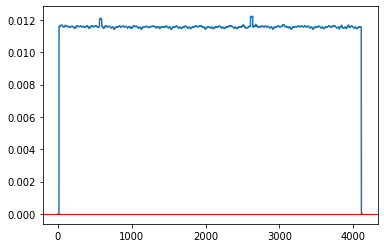

100%|██████████| 4677/4677 [00:00<00:00, 851569.71it/s]


(4677, 30, 56)


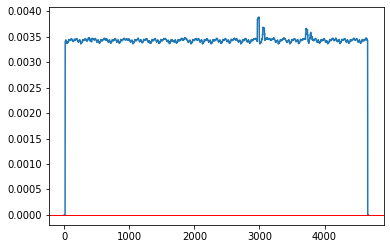

100%|██████████| 1583/1583 [00:00<00:00, 527872.73it/s]


(1583, 30, 56)


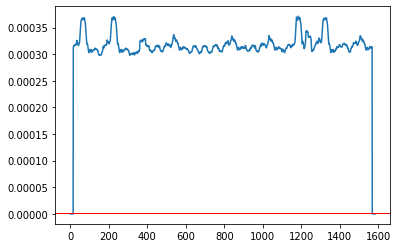

100%|██████████| 2003/2003 [00:00<00:00, 1194029.41it/s]


(2003, 30, 56)


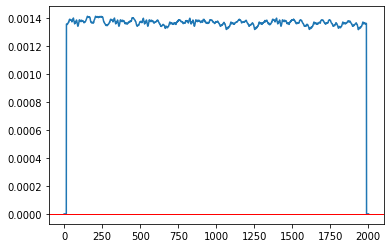

100%|██████████| 4727/4727 [00:00<00:00, 755726.13it/s]


(4727, 30, 56)


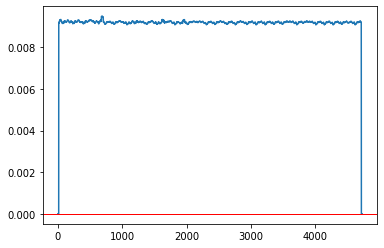

100%|██████████| 7255/7255 [00:00<00:00, 1023982.08it/s]


(7255, 30, 56)


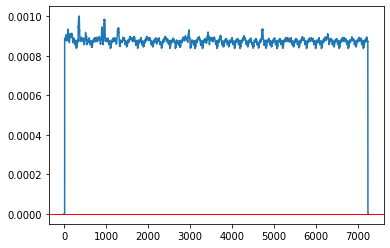

100%|██████████| 901/901 [00:00<00:00, 1272413.44it/s]


(901, 30, 56)


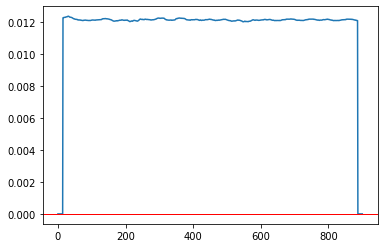

100%|██████████| 3049/3049 [00:00<00:00, 758462.30it/s]


(3049, 30, 56)


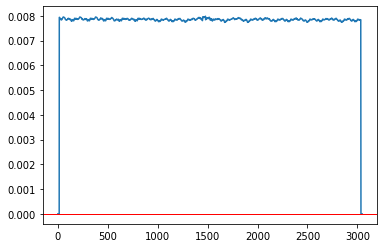

100%|██████████| 1685/1685 [00:00<00:00, 647791.22it/s]


(1685, 30, 56)


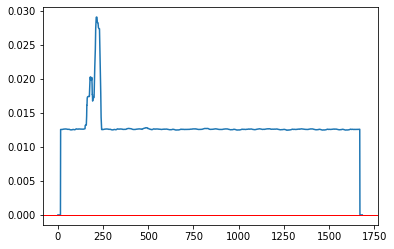

100%|██████████| 4231/4231 [00:00<00:00, 646111.56it/s]


(4231, 30, 56)


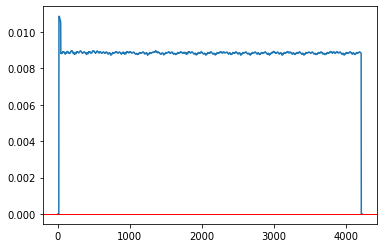

100%|██████████| 6287/6287 [00:00<00:00, 1203047.09it/s]


(6287, 30, 56)


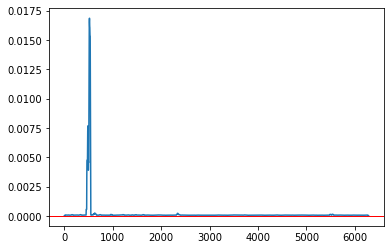

100%|██████████| 1187/1187 [00:00<00:00, 582160.76it/s]


(1187, 30, 56)


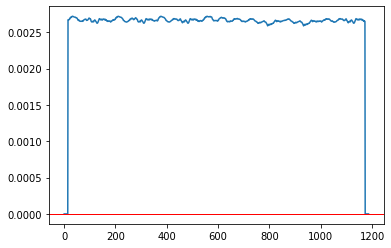

100%|██████████| 3685/3685 [00:00<00:00, 771681.57it/s]


(3685, 30, 56)


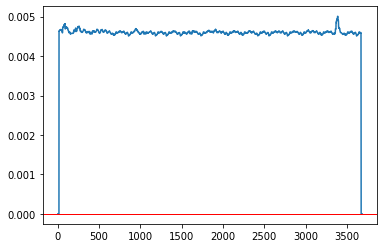

100%|██████████| 159/159 [00:00<00:00, 520198.39it/s]


(159, 30, 56)


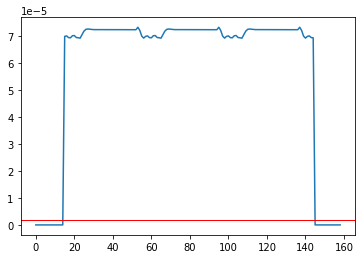

100%|██████████| 3093/3093 [00:00<00:00, 873248.67it/s]


(3093, 30, 56)


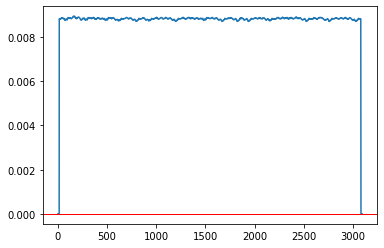

100%|██████████| 7419/7419 [00:00<00:00, 1186017.51it/s]


(7419, 30, 56)


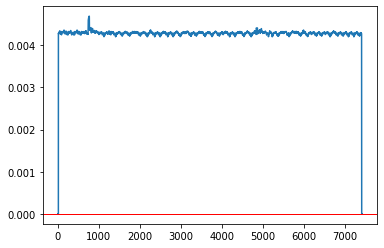

100%|██████████| 6287/6287 [00:00<00:00, 675346.75it/s]


(6287, 30, 56)


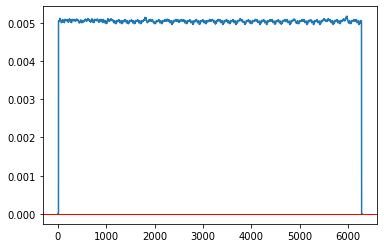

100%|██████████| 4063/4063 [00:00<00:00, 1002320.74it/s]


(4063, 30, 56)


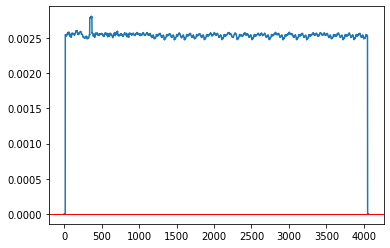

100%|██████████| 1995/1995 [00:00<00:00, 714632.89it/s]


(1995, 30, 56)


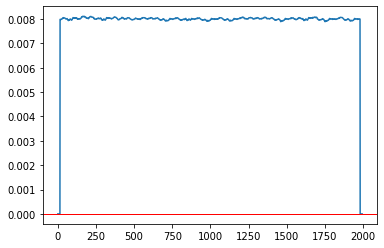

100%|██████████| 4943/4943 [00:00<00:00, 811191.98it/s]


(4943, 30, 56)


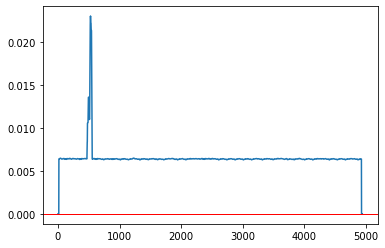

100%|██████████| 3831/3831 [00:00<00:00, 841276.37it/s]


(3831, 30, 56)


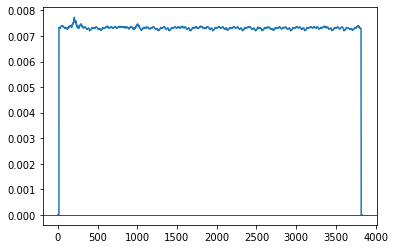

100%|██████████| 8537/8537 [00:00<00:00, 1262090.63it/s]


(8537, 30, 56)


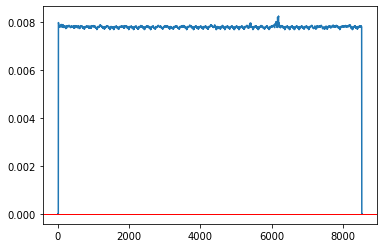

100%|██████████| 3215/3215 [00:00<00:00, 1075591.24it/s]


(3215, 30, 56)


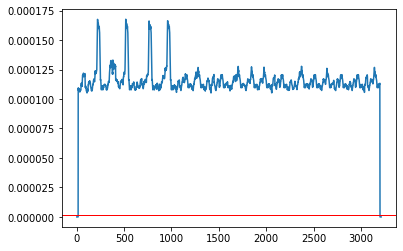

100%|██████████| 1487/1487 [00:00<00:00, 720532.58it/s]


(1487, 30, 56)


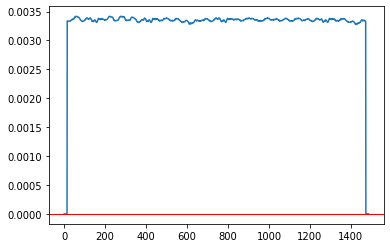

100%|██████████| 2345/2345 [00:00<00:00, 656103.19it/s]


(2345, 30, 56)


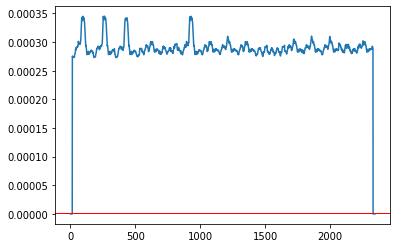

100%|██████████| 2145/2145 [00:00<00:00, 797021.80it/s]


(2145, 30, 56)


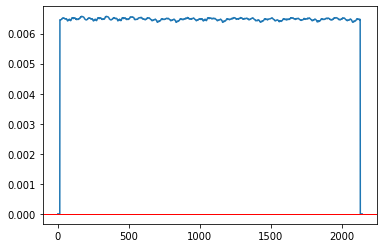

100%|██████████| 5057/5057 [00:00<00:00, 1022936.84it/s]


(5057, 30, 56)


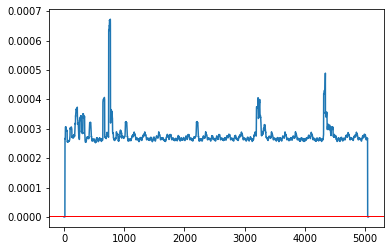

 13%|█▎        | 95/758 [02:52<20:06,  1.82s/it]


KeyboardInterrupt: ignored

In [237]:
testing('CVE-2014-0160',2*1e-6)
testing('CVE-2014-0160',3*1e-6)
testing('CVE-2014-0160',4*1e-6)
testing('CVE-2014-0160',5*1e-6)
testing('CVE-2014-0160',6*1e-6)
testing('CVE-2014-0160',7*1e-6)
testing('CVE-2014-0160',8*1e-6)
testing('CVE-2014-0160',9*1e-6)